In [1]:
import numpy as np
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from PyAstronomy.pyasl import rotBroad
import numpy as np
from math import sin, pi
from scipy.special import erf                               # Error function
from scipy.signal import fftconvolve 

In [2]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    #bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux

In [3]:
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')

In [100]:
import numpy as np
from scipy.signal import find_peaks
from astropy import constants, units

def vsini(wave, flux, epsilon=0.6, clam=None, window=None):
    cc = constants.c.to(units.AA / units.s).value

    if window is not None:
        keep = (window[0] <= wave) & (wave <= window[1])
        wave, flux = wave[keep], flux[keep]

    clam = clam or np.mean(wave)

    q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

    freqs, ampls = np.fft.fftfreq(len(wave), 0.05), np.abs(np.fft.fft(1 - flux))
    ampls /= max(ampls)

    peaks, _ = find_peaks(ampls)
    minima = freqs[peaks][:-1]
    minvals = ampls[peaks][:-1]

    freqs = freqs * clam / q1 / cc
    vsini_values = cc / clam * q1 / minima

    error = np.ptp(wave) * clam / q1 / cc

    return (freqs, ampls), (minima, minvals), vsini_values/10**13, error

In [ ]:
result = vsini(wave, flux, clam = 4471, window=[4465, 4478])

In [ ]:
max(result[2])

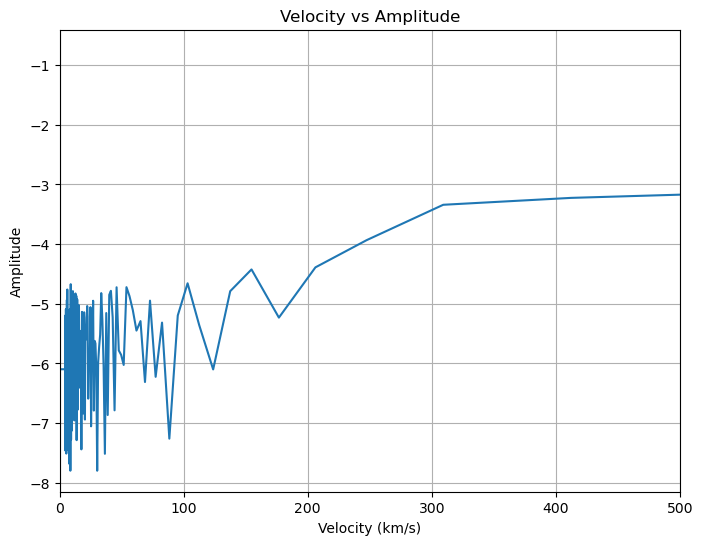

In [103]:
clam = 4471
epsilon = 0.6
cc = constants.c.to(units.AA / units.s).value
q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4
freqs = result[0][0] /( clam / q1 / cc)
ampls = result[0][1]
def freq_to_velocity(freqs, clam, q1):
    cc = constants.c.to(units.AA / units.s).value
    return (cc / clam * q1 / freqs)/10**13

# Convert frequencies to velocities
velocities = freq_to_velocity(freqs, clam, q1)


# Plot velocity vs amplitude
plt.figure(figsize=(8, 6))
plt.plot(velocities, np.log(ampls))
plt.ylabel('Amplitude')
plt.xlabel('Velocity (km/s)')
plt.title('Velocity vs Amplitude')
plt.grid(True)
plt.xlim(0,500)
#plt.ylim(0,0.1)
plt.show()

In [84]:
def nadaraya_watson_kernel_smooth(x, y, bandwidth=0.5, kernel='gaussian'):
    smoothed_y = np.zeros_like(y)
    for i in range(len(x)):
        weights = np.exp(-(x - x[i])**2 / (2 * bandwidth**2)) if kernel == 'gaussian' else None  # Gaussian kernel
        smoothed_y[i] = np.sum(weights * y) / np.sum(weights) if weights is not None else y[i]  # Nadaraya-Watson formula
    return smoothed_y




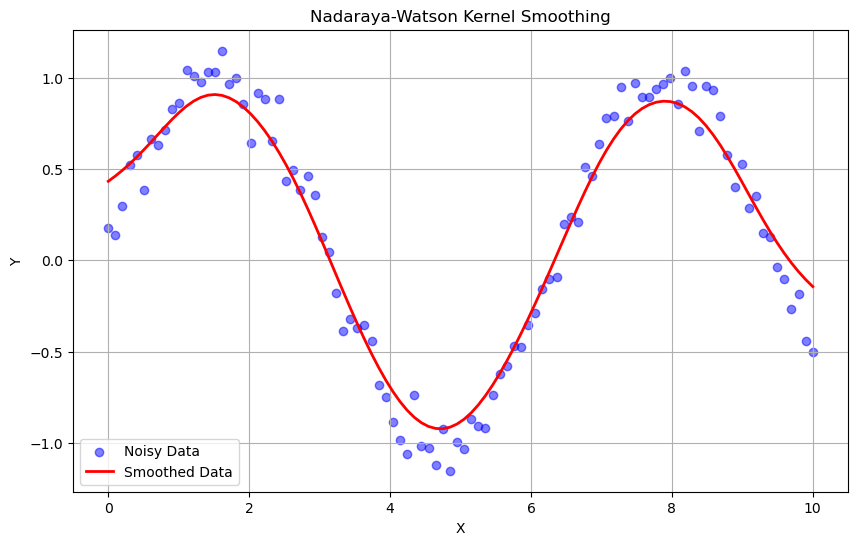

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def nadaraya_watson_kernel_smooth(x, y, bandwidth=0.5, kernel='gaussian'):
    smoothed_y = np.zeros_like(y)
    for i in range(len(x)):
        weights = np.exp(-(x - x[i])**2 / (2 * bandwidth**2)) if kernel == 'gaussian' else None  # Gaussian kernel
        smoothed_y[i] = np.sum(weights * y) / np.sum(weights) if weights is not None else y[i]  # Nadaraya-Watson formula
    return smoothed_y

# Generate noisy data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=x.shape)

# Smooth the data using Nadaraya-Watson kernel smoothing
smoothed_y = nadaraya_watson_kernel_smooth(x, y, bandwidth=0.2, kernel='gaussian')

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Noisy Data', color='blue', alpha=0.5)
plt.plot(x, smoothed_y, label='Smoothed Data', color='red', linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nadaraya-Watson Kernel Smoothing')
plt.legend()
plt.grid(True)
plt.show()

(0.97, 1.001)

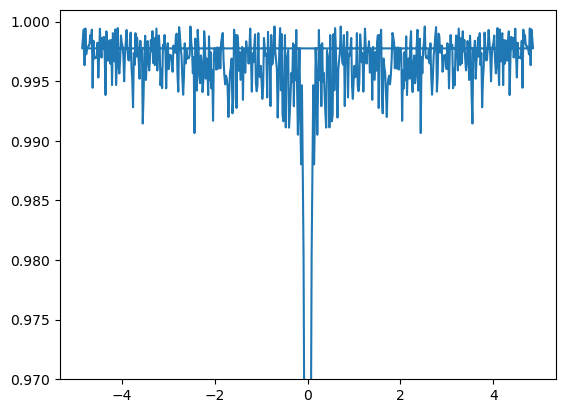

In [55]:
plt.plot(result[0][0]*1e14, 1-result[0][1])

plt.ylim(0.97, 1.001)

In [32]:


keep = (4465 <= wave) & (wave <= 4478)
wave, flux = wave[keep], flux[keep]

clam = 4471
epsilon = 0.6
cc = constants.c.to(units.AA / units.s).value

q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

freqs, ampls = np.fft.fftfreq(len(wave), np.diff(wave)[0]), np.abs(np.fft.fft(1 - flux))
ampls /= max(ampls)

peaks, _ = find_peaks(ampls)
minima = freqs[peaks][:-1]
minvals = ampls[peaks][:-1]

freqs = freqs * clam / q1 / cc
vsini_values = cc / clam * q1 / minima

error = np.ptp(wave) * clam / q1 / cc

In [28]:
cc

2.9979245799999995e+18

In [33]:
vsini_values = vsini_values/10**13

In [34]:
vsini_values

array([ 71.80755295,  47.87170197,  38.29736157,  33.79178962,
        30.23475914,  24.97654016,  21.27631199,  19.14868079,
        17.40789162,  15.52595739,  13.05591872,  12.48827008,
        11.96792549,  11.48920847,  11.04731584,  10.25822185,
         9.73661735,   9.11841942,   8.57403617,   8.32551339,
         7.86932087,   7.65947231,   7.46052498,   7.1807553 ,
         6.92120992,   6.75835792,   6.52795936,   6.3828936 ,
         6.1769938 ,   5.86184106,   5.63196494,   5.319078  ,
         5.17531913,   5.08372056,   4.90991815,   4.82739852,
         4.74760681,   4.67040995,   4.55920971,   4.41892634,
         4.31925131,   4.19314178,   4.10328874,   4.04549594,
         3.90789404,   3.85543908,   3.80437367,   3.73026249,
         3.59037765,   3.50280746,   3.43988278,   3.37917896,
         3.33988618,   3.28263099,   3.22730575,   3.1914468 ,
         3.15637595,   3.0884969 ,   3.03947314,   3.0076462 ,
         2.97647888,   2.93092053,   2.87230212,   2.81

### hermes spectra

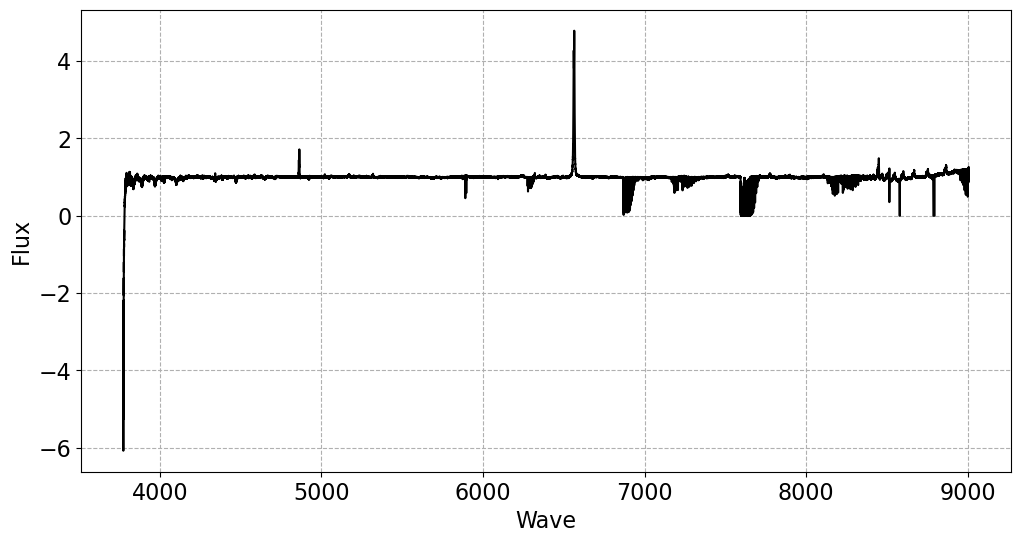

In [3]:
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
plt.figure(figsize=(12, 6))
plt.plot(wave, flux, color='black')
plt.grid(True, linestyle = '--')
plt.xlabel('Wave', fontsize=16)
plt.ylabel('Flux', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### model atmosphere

In [73]:
import glob
import gzip
import pandas as pd
import os
from scipy.interpolate import interp1d

In [112]:
model_files = glob.glob('BCvispec_v10/*')
vis_7_files = {}
vis_17_files = {}

for file_name in model_files:
    name_without_extension = file_name.split('/')[-1].split('.')[0]  # Extracting the file name without extension
    
    if 'CN' not in name_without_extension:
        continue
    if 'vis.7' in file_name:
        vis_7_files[name_without_extension] = file_name
    elif 'vis.17' in file_name:
        vis_17_files[name_without_extension] = file_name

vis_7_files_list = list(vis_7_files.values())
vis_17_files_sorted = {key: vis_17_files[key] for key in vis_7_files.keys()}
vis_17_files_list = list(vis_17_files_sorted.values())

In [ ]:
def read_data(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file, delim_whitespace=True, names=['wave', 'flux'])
    return df

def normalize_flux(df_17, df_7):
    normalized_flux = df_7['flux'] / df_17['flux']
    return normalized_flux

def interpolate_flux(df_17, df_7):
    interp_func = interp1d(df_17['wave'], df_17['flux'], kind='linear', fill_value='extrapolate')
    interpolated_flux = interp_func(df_7['wave'])
    return interpolated_flux

input_directory = "BCvispec_v10/"
output_directory = "normalized_data/"
os.makedirs(output_directory, exist_ok=True)

for file_17, file_7 in zip(vis_17_files_list, vis_7_files_list):
    df_17 = read_data(file_17)
    df_7 = read_data(file_7)
    
    #debug stuff
    #print("Columns of df_7:", df_7.columns)
    #print("Columns of interpolated_df_17:", interpolated_df_17.columns)

    interpolated_flux = interpolate_flux(df_17, df_7)
    interpolated_df_17 = pd.DataFrame({'wave': df_7['wave'], 'flux': interpolated_flux})
    normalized_flux = normalize_flux(interpolated_df_17, df_7)
    normalized_df = pd.DataFrame({'wave': df_7['wave'], 'normalized_flux': normalized_flux})
    file_name_without_extension = os.path.splitext(os.path.basename(file_17))[0]
    output_file_path = os.path.join(output_directory, f"{file_name_without_extension}_normalized.csv")
    normalized_df.to_csv(output_file_path, index=False)

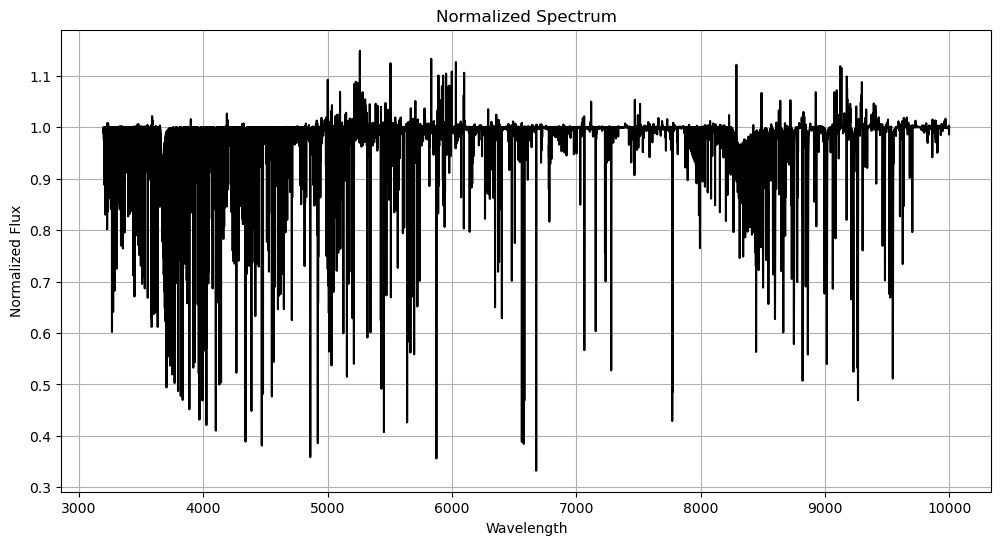

In [118]:
df = pd.read_csv('normalized_data/BC15000g175v10CN.vis.17_normalized.csv')
plt.figure(figsize=(12, 6))
plt.plot(df['wave'], df['normalized_flux'], color='black')
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('Normalized Spectrum')
plt.grid(True)
plt.show()

### model fitting
#### now we want to fit the models to the spectra by choosing a few lines

In [66]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from PyAstronomy.pyasl import rotBroad
import numpy as np
from math import sin, pi
from scipy.special import erf                               # Error function
from scipy.signal import fftconvolve 

# Settings & constants
binSize = 0.01   # Size of wavelength bins to resample input spectrum to
finalBins = 0.01 # Size of wavelength bins of output spectrum after broadening
limbDark = 0.6   # Limb darkening coefficient to be used by rotational broadening
c = 299792.458   # Speed of light in km/s

def read_spectrum(filename):
    try:
        wlc, flux = np.loadtxt(filename, unpack=True, skiprows=1)
        return wlc, flux
    except IOError:
        print("Input spectrum " + filename + " not found!")
        return None, None

def resample_spectrum(wlc, flux, new_bin_size):
    new_wlc = np.arange(wlc[0] + new_bin_size, wlc[-1] - new_bin_size, new_bin_size)
    new_flux = np.interp(new_wlc, wlc, flux)
    return new_wlc, new_flux

#def instr_broaden(wlc, flux, resolving_power):
#    return instrBroadGaussFast(wlc, flux, resolving_power, maxsig=5.0, edgeHandling="firstlast")

def rot_broaden(wlc, flux, vrot):
    return rotBroad(wlc, flux, limbDark, vrot)

def macro_broaden(xdata, ydata, vmacro):
    sq_pi = np.sqrt(np.pi)
    lambda0 = np.median(xdata)
    xspacing = xdata[1] - xdata[0]
    mr = vmacro * lambda0 / c
    ccr = 2 / (sq_pi * mr)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmr = abs(px) / mr
    profile = ccr * (np.exp(-pxmr ** 2) + sq_pi * pxmr * (erf(pxmr) - 1.0))

    before = ydata[int(-profile.size / 2 + 1):]
    after = ydata[:int(profile.size / 2)]
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    x2 = np.linspace(first, last, extended.size)

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return newydata

def resample_final(wlc, flux, final_bin_size):
    if final_bin_size != binSize:
        new_wlc = np.arange(wlc[0] + final_bin_size, wlc[-1] - final_bin_size, final_bin_size)
        new_flux = np.interp(new_wlc, wlc, flux)
        return new_wlc, new_flux
    else:
        return wlc, flux

def write_output(filename, wlc, flux):
    with open(filename, 'w') as out_f:
        out_f.write("#" + str(len(wlc)) + "\t" + "#0 \n")
        for i in range(len(wlc) - 1):
            out_f.write(str(wlc[i]) + "\t" + str(flux[i]) + "\n")

def broaden_spectrum(filename, vrot, vmacro):
    wlc, flux = read_HERMES(filename) #read_spectrum(filename)
    if wlc is None or flux is None:
        return
    wlc, flux = resample_spectrum(wlc, flux, binSize)
    #flux = instr_broaden(wlc, flux, resolving_power)
    flux = rot_broaden(wlc, flux, vrot)
    if vmacro != -1:
        flux = macro_broaden(wlc, flux, vmacro)
    wlc, flux = resample_final(wlc, flux, finalBins)
    #write_output(filename + ".fin", wlc, flux)
    return wlc, flux

In [140]:
#wvl, flx = broaden_spectrum('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits', 250, 150)
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')

In [17]:
import warnings
class Model_broad:
    def __init__(self, wave, flux):
        self.x = wave
        self.y = flux
model = Model_broad(wave, flux)


def Broaden(model, vsini, epsilon=0.5, linear=False, findcont=False):
    # Remove NaN values from the flux array and corresponding wavelength values
    non_nan_idx = ~np.isnan(model.y)
    wave = model.x[non_nan_idx]
    flux = model.y[non_nan_idx]
    
    if not linear:
        x = np.logspace(np.log10(wave[0]), np.log10(wave[-1]), len(wave))
    else:
        x = wave
        
    if findcont:
        # Find the continuum
        model.cont = np.ones_like(flux)  # Placeholder for continuum finding
        
    # Make the broadening kernel
    dx = np.log(x[1] / x[0])
    c = 299792458  # Speed of light in m/s
    lim = vsini / c
    if lim < dx:
        warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
        return Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    
    d_logx = np.arange(0.0, lim, dx)
    d_logx = np.concatenate((-d_logx[::-1][:-1], d_logx))
    alpha = 1.0 - (d_logx / lim) ** 2
    B = (1.0 - epsilon) * np.sqrt(alpha) + epsilon * np.pi * alpha / 4.0  # Broadening kernel
    B /= np.sum(B)  # Normalize

    # Do the convolution
    broadened = Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    broadened.y = fftconvolve(flux, B, mode='same')
    
    return broadened

In [118]:
broadened_model1= Broaden(model, 150000)
wv = broadened_model1.x
fl = broadened_model1.y

broadened_model2= Broaden(model, 400000)
wv2 = broadened_model2.x
fl2 = broadened_model2.y


In [132]:
start_wavelength = 4465
end_wavelength = 4480
num_points = 100  # Number of equispaced points within the range

# Find the indices corresponding to the specified range
indices = np.where((wave >= start_wavelength) & (wave <= end_wavelength))[0]

# Select the wavelength and flux values within the specified range
selected_wave = wave[indices]
selected_flux = flux[indices]

# Generate equispaced wavelengths within the specified range
equispaced_wave = np.linspace(start_wavelength, end_wavelength, num_points)

# Interpolate flux values corresponding to the equispaced wavelengths
equispaced_flux = np.interp(equispaced_wave, selected_wave, selected_flux)

In [125]:
wv3 = equispaced_wave
fl3 = rot_broaden(equispaced_wave, equispaced_flux, 150)

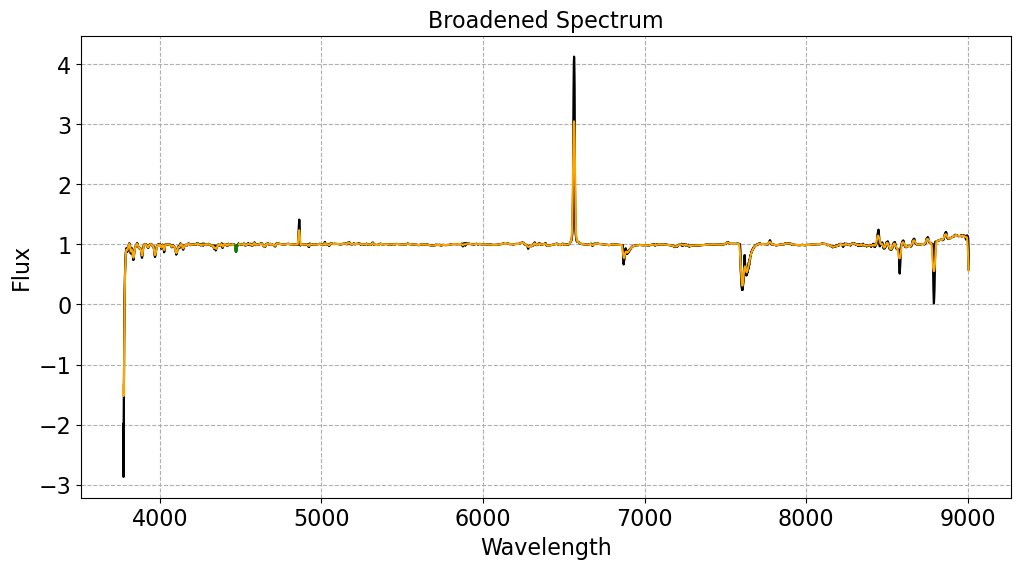

In [128]:
plt.figure(figsize=(12, 6))
plt.plot(wv, fl, color='black')
plt.plot(wv, fl, color='black')
plt.plot(wv2, fl2, color='orange')
plt.plot(wv3, fl3, color='green')
#plt.plot(wave, flux, color='blue')
plt.xlabel('Wavelength', fontsize=16)
plt.ylabel('Flux', fontsize=16)
plt.title('Broadened Spectrum', fontsize=16)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.5, 1.25)
#plt.xlim(4465, 4480)
plt.show()

### macroturb

In [11]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')

def macro_broaden(xdata, ydata, vmacro):
    sq_pi = np.sqrt(np.pi)
    lambda0 = np.median(xdata)
    xspacing = xdata[1] - xdata[0]
    mr = vmacro * lambda0 / c
    ccr = 2 / (sq_pi * mr)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmr = abs(px) / mr
    profile = ccr * (np.exp(-pxmr ** 2) + sq_pi * pxmr * (erf(pxmr) - 1.0))

    before = ydata[int(-profile.size / 2 + 1):]
    after = ydata[:int(profile.size / 2)]
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    x2 = np.linspace(first, last, extended.size)  #newdata x array ==> handles edge effects

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return x2, newydata

def broaden_spectrum(wlc,flux, vmacro): #macroturbulence broadening
    #wlc, flux = read_HERMES(filename) #read_spectrum(filename)
    if wlc is None or flux is None:
        return
    wlc, flux = resample_spectrum(wlc, flux, binSize)
    #flux = instr_broaden(wlc, flux, resolving_power)
    #flux = rot_broaden(wlc, flux, vrot)
    if vmacro != -1:
        flux = macro_broaden(wlc, flux, vmacro)
    wlc, flux = resample_final(wlc, flux, finalBins)
    #write_output(filename + ".fin", wlc, flux)
    return wlc, flux

def resample_final(wlc, flux, final_bin_size):
    if final_bin_size != binSize:
        new_wlc = np.arange(wlc[0] + final_bin_size, wlc[-1] - final_bin_size, final_bin_size)
        new_flux = np.interp(new_wlc, wlc, flux)
        return new_wlc, new_flux
    else:
        return wlc, flux
def resample_spectrum(wlc, flux, new_bin_size):
    new_wlc = np.arange(wlc[0] + new_bin_size, wlc[-1] - new_bin_size, new_bin_size)
    new_flux = np.interp(new_wlc, wlc, flux)
    return new_wlc, new_flux

In [157]:
start_wavelength = 4465
end_wavelength = 4480
num_points = 100  # Number of equispaced points within the range

# Find the indices corresponding to the specified range
indices = np.where((wave >= start_wavelength) & (wave <= end_wavelength))[0]

# Select the wavelength and flux values within the specified range
selected_wave = wave[indices]
selected_flux = flux[indices]

# Generate equispaced wavelengths within the specified range
equispaced_wave = np.linspace(start_wavelength, end_wavelength, num_points)

# Interpolate flux values corresponding to the equispaced wavelengths
equispaced_flux = np.interp(equispaced_wave, selected_wave, selected_flux)

In [158]:
wv, flx = broaden_spectrum(equispaced_wave, equispaced_flux,250)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(wave, flux, color='black')
plt.plot(wv, flx, color='red')
plt.xlabel('Wavelength', fontsize=16)
plt.ylabel('Flux', fontsize=16)
plt.title('Broadened Spectrum', fontsize=16)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.5, 1.25)
#plt.xlim(4465, 4480)
plt.show()

### fitting 

In [18]:
def read_line_list(filename):
    line_centers = []
    line_widths = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespaces
            if not line:
                continue  # Skip empty lines
            parts = line.split()
            center = float(parts[0])
            if len(parts) > 1:
                width = float(parts[1])
            else:
                width = 10.0  # Default width if not provided
            line_centers.append(center)
            line_widths.append(width)

    return line_centers, line_widths

In [19]:
line_centers, line_widths = read_line_list('line_list.txt')

In [37]:
def prepare_data_for_fitting(xdata, ydata, line_centers, line_widths):
        prepared_data = []

        for center, width in zip(line_centers, line_widths):
            # Calculate the boundaries for cutting the spectrum
            start_wavelength = center - width / 2
            end_wavelength = center + width / 2

            # Find indices corresponding to the specified range
            indices = np.where((xdata >= start_wavelength) & (xdata <= end_wavelength))[0]

            # Keep only the wavelengths and fluxes within the specified range
            prepared_xdata = xdata[indices]
            prepared_ydata = ydata[indices]

            # Store the prepared data as a tuple
            prepared_data.append((prepared_xdata, prepared_ydata))

        return prepared_data
'''
def prepare_data_for_fitting(xdata, ydata, line_centers, line_widths):
    prepared_xdata = []
    prepared_ydata = []

    for center, width in zip(line_centers, line_widths):
        # Calculate the boundaries for cutting the spectrum
        start_wavelength = center - width / 2
        end_wavelength = center + width / 2

        # Find indices corresponding to the specified range
        indices = np.where((xdata >= start_wavelength) & (xdata <= end_wavelength))[0]

        # Keep only the wavelengths and fluxes within the specified range
        prepared_xdata.append(xdata[indices])
        prepared_ydata.append(ydata[indices])

    # Concatenate the prepared data
    prepared_xdata = np.concatenate(prepared_xdata)
    prepared_ydata = np.concatenate(prepared_ydata)

    return prepared_xdata, prepared_ydata
'''

'\ndef prepare_data_for_fitting(xdata, ydata, line_centers, line_widths):\n    prepared_xdata = []\n    prepared_ydata = []\n\n    for center, width in zip(line_centers, line_widths):\n        # Calculate the boundaries for cutting the spectrum\n        start_wavelength = center - width / 2\n        end_wavelength = center + width / 2\n\n        # Find indices corresponding to the specified range\n        indices = np.where((xdata >= start_wavelength) & (xdata <= end_wavelength))[0]\n\n        # Keep only the wavelengths and fluxes within the specified range\n        prepared_xdata.append(xdata[indices])\n        prepared_ydata.append(ydata[indices])\n\n    # Concatenate the prepared data\n    prepared_xdata = np.concatenate(prepared_xdata)\n    prepared_ydata = np.concatenate(prepared_ydata)\n\n    return prepared_xdata, prepared_ydata\n'

In [38]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')

In [39]:
prepared_data = prepare_data_for_fitting(wave, flux, line_centers= line_centers, line_widths= line_widths)

In [40]:
len(prepared_data)

3

In [23]:
prepared_xdata = prepared_data[0]
prepared_ydata = prepared_data[1]

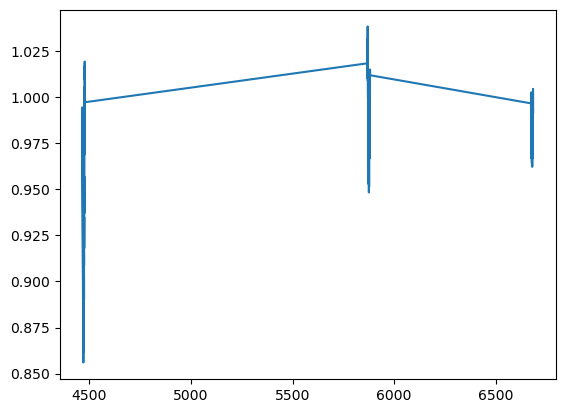

In [36]:
plt.plot(prepared_xdata, prepared_ydata)

In [34]:
from lmfit import Model, Parameters


def fitting_function_lmfit(prepared_data, params, line_widths, line_centers):
    vsini = params['vsini'].value
    #vmacro = params['vmacro'].value
    
    for i in range(0, len(prepared_xdata)):
        heights = params['A'+str(i)].value

    model_spectrum = np.zeros_like(prepared_xdata[0])
    
    for i, prepared_xdata_piece in enumerate(prepared_xdata):
        gaussian_profile = heights * np.exp(-0.5 * ((prepared_xdata_piece - line_centers[i]) / line_widths[i])**2)
        broadened_gaussian = Broaden(prepared_xdata_piece, gaussian_profile, vsini)
        #broadened_gaussian = macro_broaden(prepared_xdata_piece, broadened_gaussian, vmacro)
        model_spectrum += broadened_gaussian.y

    return model_spectrum

# Define the lmfit model


params_ = Parameters()
params_.add('vsini', value=10.0)
for i in range(len(prepared_xdata)):
    params_.add('A'+str(i), value=1.0)
    
model_lm = Model(fitting_function_lmfit)


ValueError: Invalid parameter name ('params') for function fitting_function_lmfit

In [35]:
len(prepared_xdata)

1240

In [32]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

gmodel = Model(gaussian)

In [46]:

# Prepare lmfit Parameters object
params = Parameters()
params.add('vsini', value=10.0)  # Initial guess for vsini
#params.add('vmacro', value=5.0)   # Initial guess for vmacro
for i in range(len(prepared_xdata)):
    params.add(f'A{i}', value=1.0)  # Initial guess for Gaussian heights

# Perform the fit
result = model.fit(prepared_ydata, params, prepared_xdata=prepared_xdata, line_width=line_widths, line_centers=line_centers)

# Extract optimized parameters
optimized_params = result.params
optimized_vsini = optimized_params['vsini'].value
#optimized_vmacro = optimized_params['vmacro'].value
optimized_heights = [optimized_params[f'A{i}'].value for i in range(len(prepared_xdata))]

AttributeError: 'Model' object has no attribute 'fit'

In [41]:
from lmfit import Model

def gaussian(x, amp, center, sigma):
    return amp * np.exp(-(x - center)**2 / (2 * sigma**2))

def fitting_function(x, *params):
    # Extract parameters for each Gaussian
    num_gaussians = len(params) // 3
    gaussians = [gaussian(x, params[i], params[i+1], params[i+2]) for i in range(0, len(params), 3)]
    
    # Combine all Gaussians into one model
    model = np.sum(gaussians, axis=0)
    return model

# Create lmfit Model
model = Model(fitting_function)

ValueError: varargs '*params' is not supported

In [54]:
wavelengths, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')

AttributeError: 'list' object has no attribute 'getheader'

In [44]:
line_centers, line_widths = read_line_list('line_list.txt')

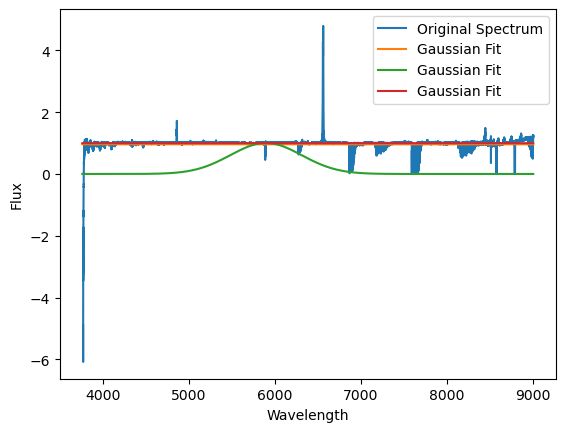

In [58]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# Define Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

# Fit Gaussian to each line
fits = []
for center, width in zip(line_centers, line_widths):
    # Define the region around the line
    region_mask = (wave >= center - width) & (wave <= center + width)
    region_wavelengths = wave[region_mask]
    region_flux = flux[region_mask]

    # Fit Gaussian to the region
    p0 = [1, center, width]  # Initial guess for Gaussian parameters
    bounds = ([0, center - 2*width, 0], [np.inf, center + 2*width, np.inf])  # Bounds for amplitude, mean, and stddev
    try:
        popt, pcov = curve_fit(gaussian, region_wavelengths, region_flux, p0=p0, bounds=bounds)
        fits.append(popt)
    except RuntimeError:
        print("Optimization failed for line at center:", center)

# Plot original spectrum and Gaussian fits
plt.plot(wave, flux, label='Original Spectrum')
for fit_params in fits:
    plt.plot(wave, gaussian(wave, *fit_params), label='Gaussian Fit')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [93]:
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')

In [94]:


import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters, minimize

def gauss(wave, a, center, sigma):
    # Function to calculate Gaussian
    return a * np.exp(-0.5 * ((wave - center) / sigma) ** 2)

def generate_data(line_centers, line_widths, wavelength_slices):
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        flux = np.random.randn(len(wave))  # Example: Replace with actual data
        wave_slices.append(wave)
        flux_slices.append(flux)
    return np.concatenate(wave_slices), np.concatenate(flux_slices)

def generate_model(params, line_centers, line_widths, wavelength_slices):
    wave_model = np.linspace(line_centers.min() - line_widths.max(), line_centers.max() + line_widths.max(), wavelength_slices)
    num_lines = len(line_centers)
    model_slices = []
    for i in range(num_lines):
        model = gauss(wave_model, params[f'a{i}'], line_centers[i], line_widths[i])
        model_slices.append(model)
    return np.sum(model_slices, axis=0)

def objective(params, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(line_centers, line_widths, wavelength_slices)
    model = generate_model(params, line_centers, line_widths, len(wave_data))
    return flux_data - model

def fit_lines(line_centers, line_widths, wavelength_slices=100):
    params = Parameters()
    num_lines = len(line_centers)
    for i in range(num_lines):
        params.add(f'a{i}', value=1)   # Initial guess for amplitude

    result = minimize(objective, params=params, args=(line_centers, line_widths, wavelength_slices))
    return result

def plot_fit_data(line_centers, line_widths, wavelength_slices=100):
    result = fit_lines(line_centers, line_widths, wavelength_slices)
    params = result.params

    wave_data, flux_data = generate_data(line_centers, line_widths, wavelength_slices)
    wave_model = np.linspace(wave_data.min(), wave_data.max(), len(wave_data))
    model = generate_model(params, line_centers, line_widths, len(wave_data))

    plt.figure(figsize=(10, 6))
    plt.plot(wave_data, flux_data, label='Data', color='blue')
    plt.plot(wave_model, model, label='Fit', color='red')
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title('Gaussian Fit')
    plt.legend()
    plt.show()

plot_fit_data(line_centers, line_widths)


AttributeError: 'list' object has no attribute 'min'

In [92]:

def gauss(wave, a, center, sigma):
    # Function to calculate Gaussian
    return a * np.exp(-0.5 * ((wave - center) / sigma) ** 2)

def generate_data(line_centers, line_widths, wavelength_slices):
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        flux = np.random.randn(len(wave))  # Example: Replace with actual data
        wave_slices.append(wave)
        flux_slices.append(flux)
    return wave_slices, flux_slices

def generate_model(params, line_centers, line_widths, wavelength_slices):
    num_lines = len(line_centers)
    model_slices = []
    for i in range(num_lines):
        wave = np.linspace(line_centers[i] - line_widths[i], line_centers[i] + line_widths[i], wavelength_slices[i])
        model = gauss(wave, params[f'a{i}'], line_centers[i], line_widths[i])
        model_slices.append(model)
    return model_slices

def objective(params, line_centers, line_widths, wavelength_slices):
    wave_slices, flux_slices = generate_data(line_centers, line_widths, wavelength_slices)
    model_slices = generate_model(params, line_centers, line_widths, wavelength_slices)
    residuals = []
    for i in range(len(wave_slices)):
        residuals.append(flux_slices[i] - model_slices[i])
    return np.concatenate(residuals)

def fit_lines(line_centers, line_widths, wavelength_slices):
    params = Parameters()
    num_lines = len(line_centers)
    for i in range(num_lines):
        params.add(f'a{i}', value=1)   # Initial guess for amplitude

    result = minimize(objective, params=params, args=(line_centers, line_widths, wavelength_slices))
    return result

def plot_fit_data(line_centers, line_widths, wavelength_slices):
    result = fit_lines(line_centers, line_widths, wavelength_slices)
    params = result.params

    wave_slices, flux_slices = generate_data(line_centers, line_widths, wavelength_slices)
    model_slices = generate_model(params, line_centers, line_widths, wavelength_slices)

    num_lines = len(line_centers)
    fig, axs = plt.subplots(num_lines, figsize=(10, 6*num_lines))

    for i in range(num_lines):
        axs[i].plot(wave_slices[i], flux_slices[i], label='Data', color='blue')
        axs[i].plot(np.linspace(line_centers[i] - line_widths[i], line_centers[i] + line_widths[i], len(model_slices[i])), model_slices[i], label='Fit', color='red')
        axs[i].set_xlabel('Wavelength')
        axs[i].set_ylabel('Flux')
        axs[i].set_title(f'Line {i+1} Gaussian Fit')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_fit_data(line_centers, line_widths, wavelength_slices)

NameError: name 'wavelength_slices' is not defined

### clean code

In [115]:
import numpy as np
from lmfit import Parameters, minimize
from scipy.interpolate import interp1d


In [116]:
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')

In [117]:


def gauss(wave, a, center, sigma):
    # Function to calculate Gaussian
    return a * np.exp(-0.5 * ((wave - center) / sigma) ** 2)


def generate_data(line_centers, line_widths, wavelength_slices):
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        # Interpolate the flux data to ensure evenly spaced wavelength slices
        interp_func = interp1d(wave, flux, kind='linear')
        new_wave = np.linspace(center - width, center + width, wavelength_slices)
        new_flux = interp_func(new_wave)
        wave_slices.append(new_wave)
        flux_slices.append(new_flux)
    return np.concatenate(wave_slices), np.concatenate(flux_slices)

def generate_model(params, line_centers, line_widths, wavelength_slices):
    num_lines = len(line_centers)
    model_slices = []
    for i in range(num_lines):
        wave = np.linspace(line_centers[i] - line_widths[i], line_centers[i] + line_widths[i], wavelength_slices)
        model = gauss(wave, params[f'a{i}'], params[f'center{i}'], params[f'sigma{i}'])
        model_slices.append(model)
    return np.concatenate(model_slices)

def objective(params, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(line_centers, line_widths, wavelength_slices)
    model = generate_model(params, line_centers, line_widths, wavelength_slices)
    return flux_data - model

def fit_lines(line_centers, line_widths, wavelength_slices=1000):
    params = Parameters()
    num_lines = len(line_centers)
    for i in range(num_lines):
        params.add(f'a{i}', value=1)   # Initial guess for amplitude
        params.add(f'center{i}', value=line_centers[i])  # Initial guess for center
        params.add(f'sigma{i}', value=line_widths[i])  # Initial guess for sigma

    result = minimize(objective, params=params, args=(line_centers, line_widths, wavelength_slices))
    return result


result = fit_lines(line_centers, line_widths)
result


In [6]:
import numpy as np
from lmfit import Parameters, minimize
from scipy.interpolate import interp1d

In [5]:
def read_line_list(filename):
    line_centers = []
    line_widths = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespaces
            if not line:
                continue  # Skip empty lines
            parts = line.split()
            center = float(parts[0])
            if len(parts) > 1:
                width = float(parts[1])
            else:
                width = 10.0  # Default width if not provided
            line_centers.append(center)
            line_widths.append(width)

    return line_centers, line_widths

In [120]:
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')

In [121]:
def gauss(x,a,center,sigma, gamma):
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma
#def gauss(wave, a, center, sigma):
#    #Function to calculate Gaussian
#    return a * np.exp(-0.5 * ((wave - center) / sigma) ** 2)
gamma = 1

def generate_data(wave, flux, line_centers, line_widths, wavelength_slices):
    interp_func = interp1d(wave, flux, kind='linear')
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        new_wave = np.linspace(center - width, center + width, wavelength_slices)
        new_flux = interp_func(new_wave)
        wave_slices.append(new_wave)
        flux_slices.append(new_flux)
    return np.concatenate(wave_slices), np.concatenate(flux_slices)

def generate_model(params, line_centers, line_widths, wavelength_slices):
    model_slices = []
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        model = gauss(wave, params[f'a{i}'], params[f'center{i}'], params[f'sigma{i}'], params[f'gamma{i}'])
        model_slices.append(model)
    return np.concatenate(model_slices)

def objective(params, wave, flux, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    model = generate_model(params, line_centers, line_widths, wavelength_slices)
    return flux_data - model

def fit_lines(wave, flux, line_centers, line_widths, wavelength_slices=1000):
    params = Parameters()
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        params.add(f'a{i}', value=-1)   # Initial guess for amplitude
        params.add(f'center{i}', value=center)  # Initial guess for center
        params.add(f'sigma{i}', value=width)  # Initial guess for sigma
        params.add(f'gamma{i}', value=gamma)


    result = minimize(objective, params=params, args=(wave_data, flux_data, line_centers, line_widths, wavelength_slices))
    return result

In [122]:
result = fit_lines(wave, flux, line_centers, line_widths)
result

### fix broadening + fix gausssian depending on fwhm

In [80]:
from PyAstronomy import pyasl
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')

In [81]:
R = 10000
def gauss(x,a,center, gamma):
  sigma = sigma = 4471/ (2.0 * R * np.sqrt(2.0 * np.log(2))) 
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma


def generate_data(wave, flux, line_centers, line_widths, wavelength_slices):
    interp_func = interp1d(wave, flux, kind='linear')
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        new_wave = np.linspace(center - width, center + width, wavelength_slices)
        new_flux = interp_func(new_wave)
        wave_slices.append(new_wave)
        flux_slices.append(new_flux)
    return np.concatenate(wave_slices), np.concatenate(flux_slices)

def generate_model(params, line_centers, line_widths, wavelength_slices):
    model_slices = []
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        instr = gauss(wave, params[f'a{i}'], params[f'center{i}'], params[f'gamma{i}'])
        model = pyasl.rotBroad(wave, instr, 0.6, params['vsini'], edgeHandling = 'firstlast')
        model_slices.append(model)
    return np.concatenate(model_slices)

def objective(params, wave, flux, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    model = generate_model(params, line_centers, line_widths, wavelength_slices)
    return flux_data - model

def fit_lines(wave, flux, line_centers, line_widths, wavelength_slices=1000):
    params = Parameters()
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        params.add(f'a{i}', value=-1)   # Initial guess for amplitude
        params.add(f'center{i}', value=center)  # Initial guess for center
        #params.add(f'sigma{i}', value=width)  # Initial guess for sigma
        params.add(f'gamma{i}', value=1)
    params.add('vsini', value=150000, min = 0, max = 500000)

    result = minimize(objective, params=params, args=(wave_data, flux_data, line_centers, line_widths, wavelength_slices))
    return result

### pyasl.rotbroad takes insane amount of time!!! why this even exists?

In [ ]:
result = fit_lines(wave, flux, line_centers, line_widths)
result

In [7]:
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')

In [8]:


def generate_data(wave, flux, line_centers, line_widths, wavelength_slices):
    interp_func = interp1d(wave, flux, kind='linear')
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        new_wave = np.linspace(center - width, center + width, wavelength_slices)
        new_flux = interp_func(new_wave)
        wave_slices.append(new_wave)
        flux_slices.append(new_flux)
    return np.concatenate(wave_slices), np.concatenate(flux_slices)



def objective(params, wave, flux, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    model = generate_model(params, line_centers, line_widths, wavelength_slices)
    return flux_data - model
'''
def gauss(x,a,center,R, gamma):
  sigma = sigma = 4471/ (2.0 * R * np.sqrt(2.0 * np.log(2))) 
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma

gamma = 1

def generate_model(params, line_centers, line_widths, wavelength_slices):
    model_slices = []
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        model = gauss(wave, params[f'a{i}'], params[f'center{i}'], params[f'sigma{i}'], params[f'gamma{i}'])
        model_slices.append(model)
    return np.concatenate(model_slices)


def fit_lines(wave, flux, line_centers, line_widths, wavelength_slices=1000):
    params = Parameters()
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        params.add(f'a{i}', value=-1)   # Initial guess for amplitude
        params.add(f'center{i}', value=center)  # Initial guess for center
        params.add(f'sigma{i}', value=width)  # Initial guess for sigma
        params.add(f'gamma{i}', value=gamma)


    result = minimize(objective, params=params, args=(wave_data, flux_data, line_centers, line_widths, wavelength_slices))
    return result
'''

"\ndef gauss(x,a,center,R, gamma):\n  sigma = sigma = 4471/ (2.0 * R * np.sqrt(2.0 * np.log(2))) \n  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma\n\ngamma = 1\n\ndef generate_model(params, line_centers, line_widths, wavelength_slices):\n    model_slices = []\n    for i, (center, width) in enumerate(zip(line_centers, line_widths)):\n        wave = np.linspace(center - width, center + width, wavelength_slices)\n        model = gauss(wave, params[f'a{i}'], params[f'center{i}'], params[f'sigma{i}'], params[f'gamma{i}'])\n        model_slices.append(model)\n    return np.concatenate(model_slices)\n\n\ndef fit_lines(wave, flux, line_centers, line_widths, wavelength_slices=1000):\n    params = Parameters()\n    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)\n    for i, (center, width) in enumerate(zip(line_centers, line_widths)):\n        params.add(f'a{i}', value=-1)   # Initial guess for amplitude\n        params.add(f'center{i}', valu

In [9]:
import warnings
class Model_broad:
    def __init__(self, wave, flux):
        self.x = wave
        self.y = flux
#model_broad = Model_broad(wave, flux)


## broadening handing edge effect
def Broaden(model, vsini, epsilon=0.5, linear=False, findcont=False):
    # Remove NaN values from the flux array and corresponding wavelength values
    non_nan_idx = ~np.isnan(model.y)
    wvl = model.x[non_nan_idx]
    flx = model.y[non_nan_idx]
    
    dwl = wvl[1] - wvl[0]
    binnu = int(np.floor((((vsini/100)/ 299792.458) * max(wvl)) / dwl)) + 1
    validIndices = np.arange(len(flx)) + binnu
    front_fl = np.ones(binnu) * flx[0]
    end_fl = np.ones(binnu) * flx[-1]
    flux = np.concatenate((front_fl, flx, end_fl))

    front_wv = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
    end_wv = wvl[-1] + (np.arange(binnu) + 1) * dwl
    wave = np.concatenate((front_wv, wvl, end_wv))



    if not linear:
        x = np.logspace(np.log10(wave[0]), np.log10(wave[-1]), len(wave))
    else:
        x = wave
        
    if findcont:
        # Find the continuum
        model.cont = np.ones_like(flux)  # Placeholder for continuum finding
        
    # Make the broadening kernel
    dx = np.log(x[1] / x[0])
    c = 299792458  # Speed of light in m/s
    lim = vsini / c
    if lim < dx:
        warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
        return Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    
    d_logx = np.arange(0.0, lim, dx)
    d_logx = np.concatenate((-d_logx[::-1][:-1], d_logx))
    alpha = 1.0 - (d_logx / lim) ** 2
    B = (1.0 - epsilon) * np.sqrt(alpha) + epsilon * np.pi * alpha / 4.0  # Broadening kernel
    B /= np.sum(B)  # Normalize

    # Do the convolution
    broadened = Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    broadened.y = fftconvolve(flux, B, mode='same')
    
    return broadened
#adding macroturb onto rot broadened gaussian

def macro_broaden(xdata, ydata, vmacro):
    sq_pi = np.sqrt(np.pi)
    lambda0 = np.median(xdata)
    xspacing = xdata[1] - xdata[0]
    mr = vmacro * lambda0 / c
    ccr = 2 / (sq_pi * mr)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmr = abs(px) / mr
    profile = ccr * (np.exp(-pxmr ** 2) + sq_pi * pxmr * (erf(pxmr) - 1.0))

    before = ydata[int(-profile.size / 2 + 1):]
    after = ydata[:int(profile.size / 2)]
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    x2 = np.linspace(first, last, extended.size)  #newdata x array ==> handles edge effects

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return x2, newydata

In [10]:
def gauss(x,a,center,R, gamma):
  sigma = sigma = 4471/ (2.0 * R * np.sqrt(2.0 * np.log(2))) 
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma

def generate_broaden( line_centers, line_widths, vsini, vmacro, wavelength_slices):
    model_slices = []
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        instrum = gauss(wave, -3.17, 4471.23419, 20000, 0.98829235)
        broad_rot = Broaden(Model_broad(wave, instrum), vsini)
        broad_wave, broad_flux = macro_broaden(broad_rot.x, broad_rot.y, vmacro)

        #does x2 actually give the edge handled wavelengths


        #interpolate final broadened spectra pieces
        interp = interp1d(broad_wave, broad_flux, kind= 'linear')
        broad_flux = interp(wave)
        model_slices.append(broad_flux)
        
    return  np.concatenate(model_slices)

In [157]:
from scipy.signal import fftconvolve
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')
wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, 1000)
broad_flux = generate_broaden(line_centers, line_widths, 307000 ,1000)


In [143]:
line_widths

[8.0]

### problem with broadening kernal ==> handling edges

(0.4, 1.2)

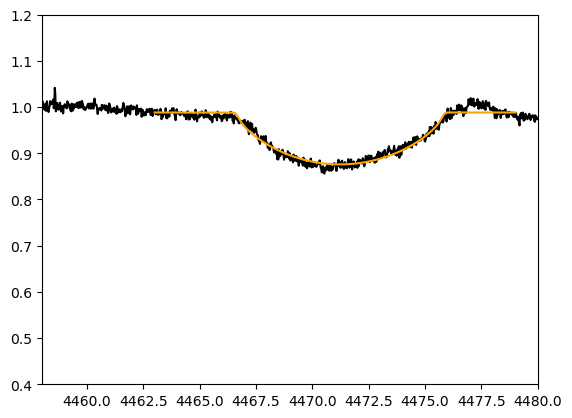

In [158]:
plt.plot(wave, flux, 'black')
plt.plot(wave_data, broad_flux, 'orange')
plt.xlim(4458, 4480)
plt.ylim(0.4, 1.2)


In [91]:
import warnings
class Model_broad:
    def __init__(self, wave, flux):
        self.x = wave
        self.y = flux
#model_broad = Model_broad(wave, flux)



def Broaden(model, vsini, epsilon=0.5, linear=False, findcont=False):
    # Remove NaN values from the flux array and corresponding wavelength values
    non_nan_idx = ~np.isnan(model.y)
    wave = model.x[non_nan_idx]
    flux = model.y[non_nan_idx]
    
    '''
    dwl = wvl[1] - wvl[0]
    binnu = int(np.floor(((vsini / 299792.458) * max(wvl)) / dwl)) + 1
    validIndices = np.arange(len(flx)) + binnu
    front_fl = np.ones(binnu) * flx[0]
    end_fl = np.ones(binnu) * flx[-1]
    flux = np.concatenate((front_fl, flx, end_fl))

    front_wv = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
    end_wv = wvl[-1] + (np.arange(binnu) + 1) * dwl
    wave = np.concatenate((front_wv, wvl, end_wv))
    '''


    if not linear:
        x = np.logspace(np.log10(wave[0]), np.log10(wave[-1]), len(wave))
    else:
        x = wave
        
    if findcont:
        # Find the continuum
        model.cont = np.ones_like(flux)  # Placeholder for continuum finding
        
    # Make the broadening kernel
    dx = np.log(x[1] / x[0])
    c = 299792458  # Speed of light in m/s
    lim = vsini / c
    if lim < dx:
        warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
        return Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    
    d_logx = np.arange(0.0, lim, dx)
    d_logx = np.concatenate((-d_logx[::-1][:-1], d_logx))
    alpha = 1.0 - (d_logx / lim) ** 2
    B = (1.0 - epsilon) * np.sqrt(alpha) + epsilon * np.pi * alpha / 4.0  # Broadening kernel
    B /= np.sum(B)  # Normalize

    # Do the convolution
    broadened = Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    broadened.y = fftconvolve(flux, B, mode='same')
    
    return broadened

In [92]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
rot_broad = Broaden(Model_broad(wave, flux), 150000) 

In [97]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
mask = (wave >= 4465) & (wave <= 4480)
vsini = 150
# Apply the mask to select the corresponding wavelengths and flux values
wvl = wave[mask]
flx = flux[mask]

dwl = wvl[1] - wvl[0]
binnu = int(np.floor(((vsini / 299792.458) * max(wvl)) / dwl)) + 1
validIndices = np.arange(len(flx)) + binnu
front_fl = np.ones(binnu) * flx[0]
end_fl = np.ones(binnu) * flx[-1]
flux = np.concatenate((front_fl, flx, end_fl))

front_wv = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
end_wv = wvl[-1] + (np.arange(binnu) + 1) * dwl
wave = np.concatenate((front_wv, wvl, end_wv))

In [98]:
flux
wave

array([4462.74970555, 4462.77292587, 4462.7961462 , 4462.81936653,
       4462.84258686, 4462.86580718, 4462.88902751, 4462.91224784,
       4462.93546816, 4462.95868849, 4462.98190882, 4463.00512915,
       4463.02834947, 4463.0515698 , 4463.07479013, 4463.09801045,
       4463.12123078, 4463.14445111, 4463.16767144, 4463.19089176,
       4463.21411209, 4463.23733242, 4463.26055274, 4463.28377307,
       4463.3069934 , 4463.33021373, 4463.35343405, 4463.37665438,
       4463.39987471, 4463.42309503, 4463.44631536, 4463.46953569,
       4463.49275602, 4463.51597634, 4463.53919667, 4463.562417  ,
       4463.58563732, 4463.60885765, 4463.63207798, 4463.65529831,
       4463.67851863, 4463.70173896, 4463.72495929, 4463.74817961,
       4463.77139994, 4463.79462027, 4463.8178406 , 4463.84106092,
       4463.86428125, 4463.88750158, 4463.9107219 , 4463.93394223,
       4463.95716256, 4463.98038289, 4464.00360321, 4464.02682354,
       4464.05004387, 4464.07326419, 4464.09648452, 4464.11970

In [25]:
from scipy.special import erf  
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve                             # Error function

In [39]:
def macro_broaden(xdata, ydata, vmacro):
    c = 299792458 
    sq_pi = np.sqrt(np.pi)
    lambda0 = np.median(xdata)
    xspacing = xdata[1] - xdata[0]
    mr = vmacro * lambda0 / c
    ccr = 2 / (sq_pi * mr)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmr = abs(px) / mr
    profile = ccr * (np.exp(-pxmr ** 2) + sq_pi * pxmr * (erf(pxmr) - 1.0))

    before = ydata[int(-profile.size / 2 + 1):]
    after = ydata[:int(profile.size / 2+1)]
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    x2 = np.linspace(first, last, extended.size)  #newdata x array ==> handles edge effects

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return newydata

In [40]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
mask = (wave >= 4465) & (wave <= 4480)
wvl = wave[mask]
flx = flux[mask]

In [41]:
new_flx = macro_broaden(wvl, flx, 150)

In [42]:
len(wvl)

645

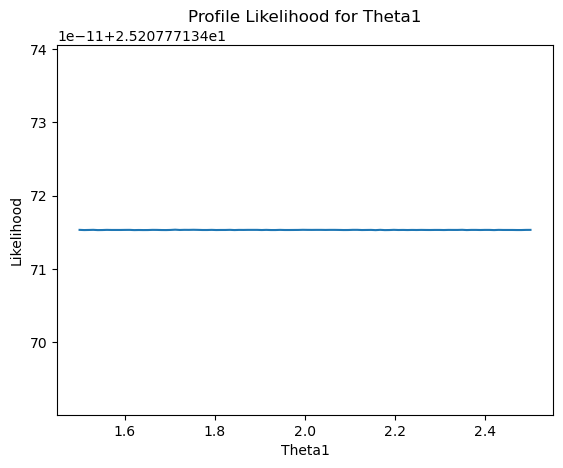

In [1]:
import numpy as np
import lmfit

# Define your model function
def model(x, theta1, theta2):
    return theta1 * x + theta2

# Generate some example data
np.random.seed(0)
x_data = np.linspace(0, 10, 100)
y_data = model(x_data, 2.0, 1.0) + np.random.normal(scale=0.5, size=len(x_data))

# Define the residual function for lmfit
def residual(params, x, data):
    theta1 = params['theta1']
    theta2 = params['theta2']
    return model(x, theta1, theta2) - data

# Create a lmfit Parameters object
params = lmfit.Parameters()
params.add('theta1', value=1.0)
params.add('theta2', value=0.0)

# Perform the fit
result = lmfit.minimize(residual, params, args=(x_data, y_data))

# Profile likelihood estimation for theta1
theta1_values = np.linspace(1.5, 2.5, 100)
likelihood_values = []

for theta1 in theta1_values:
    # Fix theta1 and fit for theta2
    params['theta1'].value = theta1
    profile_result = lmfit.minimize(residual, params, args=(x_data, y_data))
    likelihood_values.append(profile_result.chisqr)

# Plot the profile likelihood curve
import matplotlib.pyplot as plt
plt.plot(theta1_values, likelihood_values)
plt.xlabel('Theta1')
plt.ylabel('Likelihood')
plt.title('Profile Likelihood for Theta1')
plt.show()

### emcee handling errors

In [1]:
import numpy as np
import sys
from astropy.io import fits
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd
import glob
import gzip
import os
from scipy.interpolate import interp1d
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve
from PyAstronomy.pyasl import rotBroad
import numpy as np
from math import sin, pi
from scipy.special import erf                               # Error function
from scipy.signal import fftconvolve 
from lmfit import Parameters, minimize

In [2]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    #bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile, byteorder='little')
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux

#reading from linelist to fit
def read_line_list(filename):
    line_centers = []
    line_widths = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  #removing whitespaces
            if not line:
                continue  #skipping empty lines
            parts = line.split()
            center = float(parts[0])
            if len(parts) > 1:
                width = float(parts[1])
            else:
                width = 10.0  #default
            line_centers.append(center)
            line_widths.append(width)

    return line_centers, line_widths

In [3]:
def gauss(x,a,center,R, gamma):
  sigma = sigma = 4471/ (2.0 * R * np.sqrt(2.0 * np.log(2))) 
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma

def generate_data(wave, flux, line_centers, line_widths, wavelength_slices):
    interp_func = interp1d(wave, flux, kind='linear')
    wave_slices = []
    flux_slices = []
    for center, width in zip(line_centers, line_widths):
        new_wave = np.linspace(center - width, center + width, wavelength_slices)
        new_flux = interp_func(new_wave)
        wave_slices.append(new_wave)
        flux_slices.append(new_flux)
    return np.concatenate(wave_slices), np.concatenate(flux_slices)

In [4]:
import warnings
class Model_broad:
    def __init__(self, wave, flux):
        self.x = wave
        self.y = flux


def Broaden(model, vsini, epsilon=0.5, linear=False, findcont=False):
    # Remove NaN values from the flux array and corresponding wavelength values
    non_nan_idx = ~np.isnan(model.y)
    wvl = model.x[non_nan_idx]
    flx = model.y[non_nan_idx]
    
    dwl = wvl[1] - wvl[0]
    binnu = int(np.floor((((vsini/10)/ 299792.458) * max(wvl)) / dwl)) + 1 #adding extra bins for error handling
    #validIndices = np.arange(len(flx)) + binnu => this was used in rotbroad as a user cond ==> this is always on here
    front_fl = np.ones(binnu) * flx[0]
    end_fl = np.ones(binnu) * flx[-1]
    flux = np.concatenate((front_fl, flx, end_fl))

    front_wv = (wvl[0] - (np.arange(binnu) + 1) * dwl)[::-1]
    end_wv = wvl[-1] + (np.arange(binnu) + 1) * dwl
    wave = np.concatenate((front_wv, wvl, end_wv))

    if not linear:
        x = np.logspace(np.log10(wave[0]), np.log10(wave[-1]), len(wave))
    else:
        x = wave
        
    if findcont:
        # Find the continuum
        model.cont = np.ones_like(flux)  # Placeholder for continuum finding
        
    # Make the broadening kernel
    dx = np.log(x[1] / x[0])
    c = 299792458  # Speed of light in m/s
    lim = vsini / c
    if lim < dx:
        warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
        return Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    
    d_logx = np.arange(0.0, lim, dx)
    d_logx = np.concatenate((-d_logx[::-1][:-1], d_logx))
    alpha = 1.0 - (d_logx / lim) ** 2
    B = (1.0 - epsilon) * np.sqrt(alpha) + epsilon * np.pi * alpha / 4.0  # Broadening kernel
    B /= np.sum(B)  # Normalize

    # Do the convolution
    broadened = Model_broad(wave.copy(), flux.copy())  # Create a copy of the Model object
    broadened.y = fftconvolve(flux, B, mode='same')
    
    return broadened

def macro_broaden(xdata, ydata, vmacro):
    c = 299792458 #~constants.c.cgs.value * units.cm.to(units.km)
    sq_pi = np.sqrt(np.pi)
    lambda0 = np.median(xdata)
    xspacing = xdata[1] - xdata[0]
    mr = vmacro * lambda0 / c
    ccr = 2 / (sq_pi * mr)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmr = abs(px) / mr
    profile = ccr * (np.exp(-pxmr ** 2) + sq_pi * pxmr * (erf(pxmr) - 1.0))

    before = ydata[int(-profile.size / 2 + 1):]
    after = ydata[:int(profile.size / 2 +1)] #add one to fix size mismatch
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    
    x2 = np.linspace(first, last, extended.size)  #newdata x array ==> handles edge effects

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return newydata


def generate_broaden(params, line_centers, line_widths, wavelength_slices):
    model_slices = []
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        wave = np.linspace(center - width, center + width, wavelength_slices)
        
        instrum = gauss(wave, params[f'a{i}'], params[f'center{i}'], 20000, params[f'gamma{i}']) #resolution is still hardcoded R=20000 change accordingly
        broad_rot = Broaden(Model_broad(wave, instrum), params['vsini'])
        
        broad_macro = macro_broaden(broad_rot.x, broad_rot.y, params[f'vmacro{i}']) #macro broad restores the same wave array as input  
        
        interp = interp1d(broad_rot.x, broad_macro, kind= 'linear')
        broad_flux = interp(wave)
        model_slices.append(broad_flux)
        
    return  np.concatenate(model_slices)



In [5]:
def objective(params, wave, flux, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    model = generate_broaden(params, line_centers, line_widths, wavelength_slices)
    return flux_data - model

def fit_lines(wave, flux, line_centers, line_widths, wavelength_slices):
    params = Parameters()
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        params.add(f'a{i}', value=-1)   # Initial guess for amplitude
        params.add(f'center{i}', value=center)  # Initial guess for center
        params.add(f'gamma{i}', value=1)
        params.add(f'vmacro{i}', value=150000, min = 0, max = 500000)
    params.add('vsini', value=150000, min = 0, max = 500000)
    

    result = minimize(objective, params=params, args=(wave_data, flux_data, line_centers, line_widths, wavelength_slices))
    return result

In [ ]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
line_centers, line_widths = read_line_list('line_list.txt')
result = fit_lines(wave, flux, line_centers, line_widths, wavelength_slices=1000)
result

 25%|██▌       | 127/500 [02:54<04:52,  1.27it/s]/tmp/ipykernel_15796/2937870879.py:39: UserWarning: vsini too small (945.4201730641653). Not broadening!
  warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
 34%|███▍      | 169/500 [03:32<04:12,  1.31it/s]/tmp/ipykernel_15796/2937870879.py:39: UserWarning: vsini too small (684.8481563296227). Not broadening!
  warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
 37%|███▋      | 184/500 [03:44<04:52,  1.08it/s]/tmp/ipykernel_15796/2937870879.py:39: UserWarning: vsini too small (761.4320273671146). Not broadening!
  warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
 39%|███▊      | 193/500 [03:51<03:29,  1.46it/s]/tmp/ipykernel_15796/2937870879.py:39: UserWarning: vsini too small (192.3465203847736). Not broadening!
  warnings.warn("vsini too small ({}). Not broadening!".format(vsini))
 68%|██████▊   | 342/500 [05:48<02:03,  1.28it/s]/tmp/ipykernel_15796/2937870879.py:39: UserWarning:

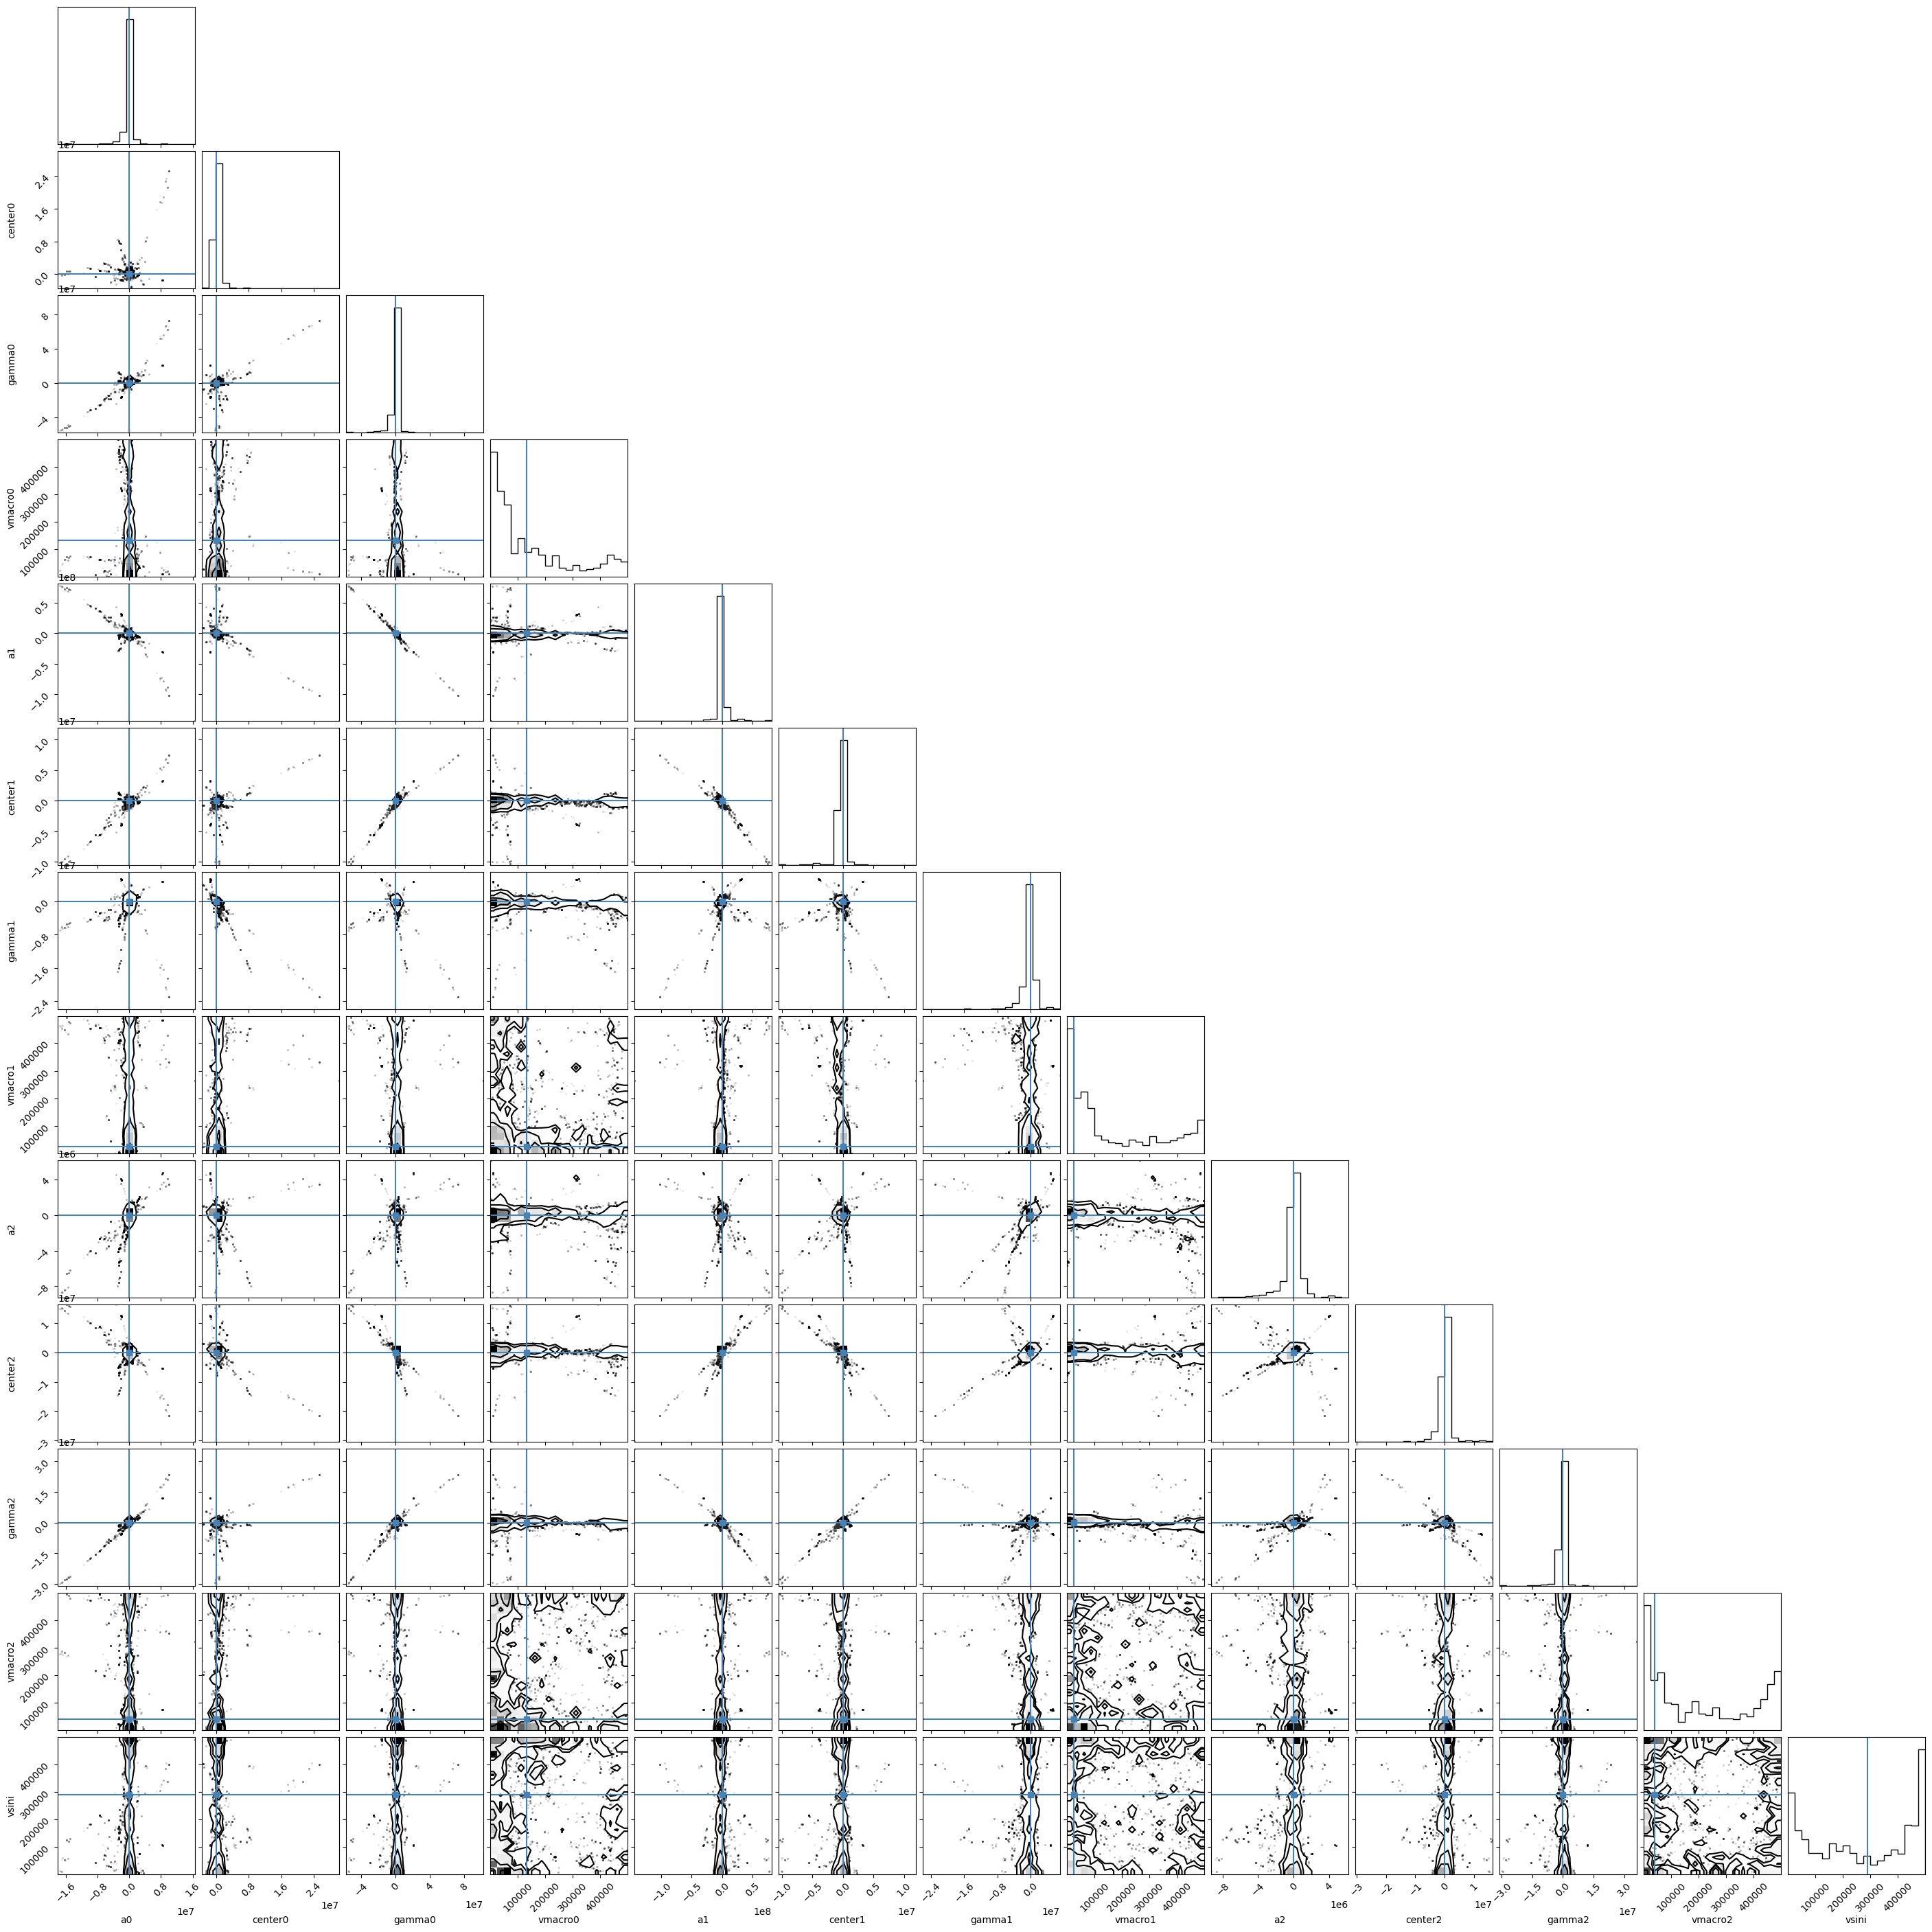

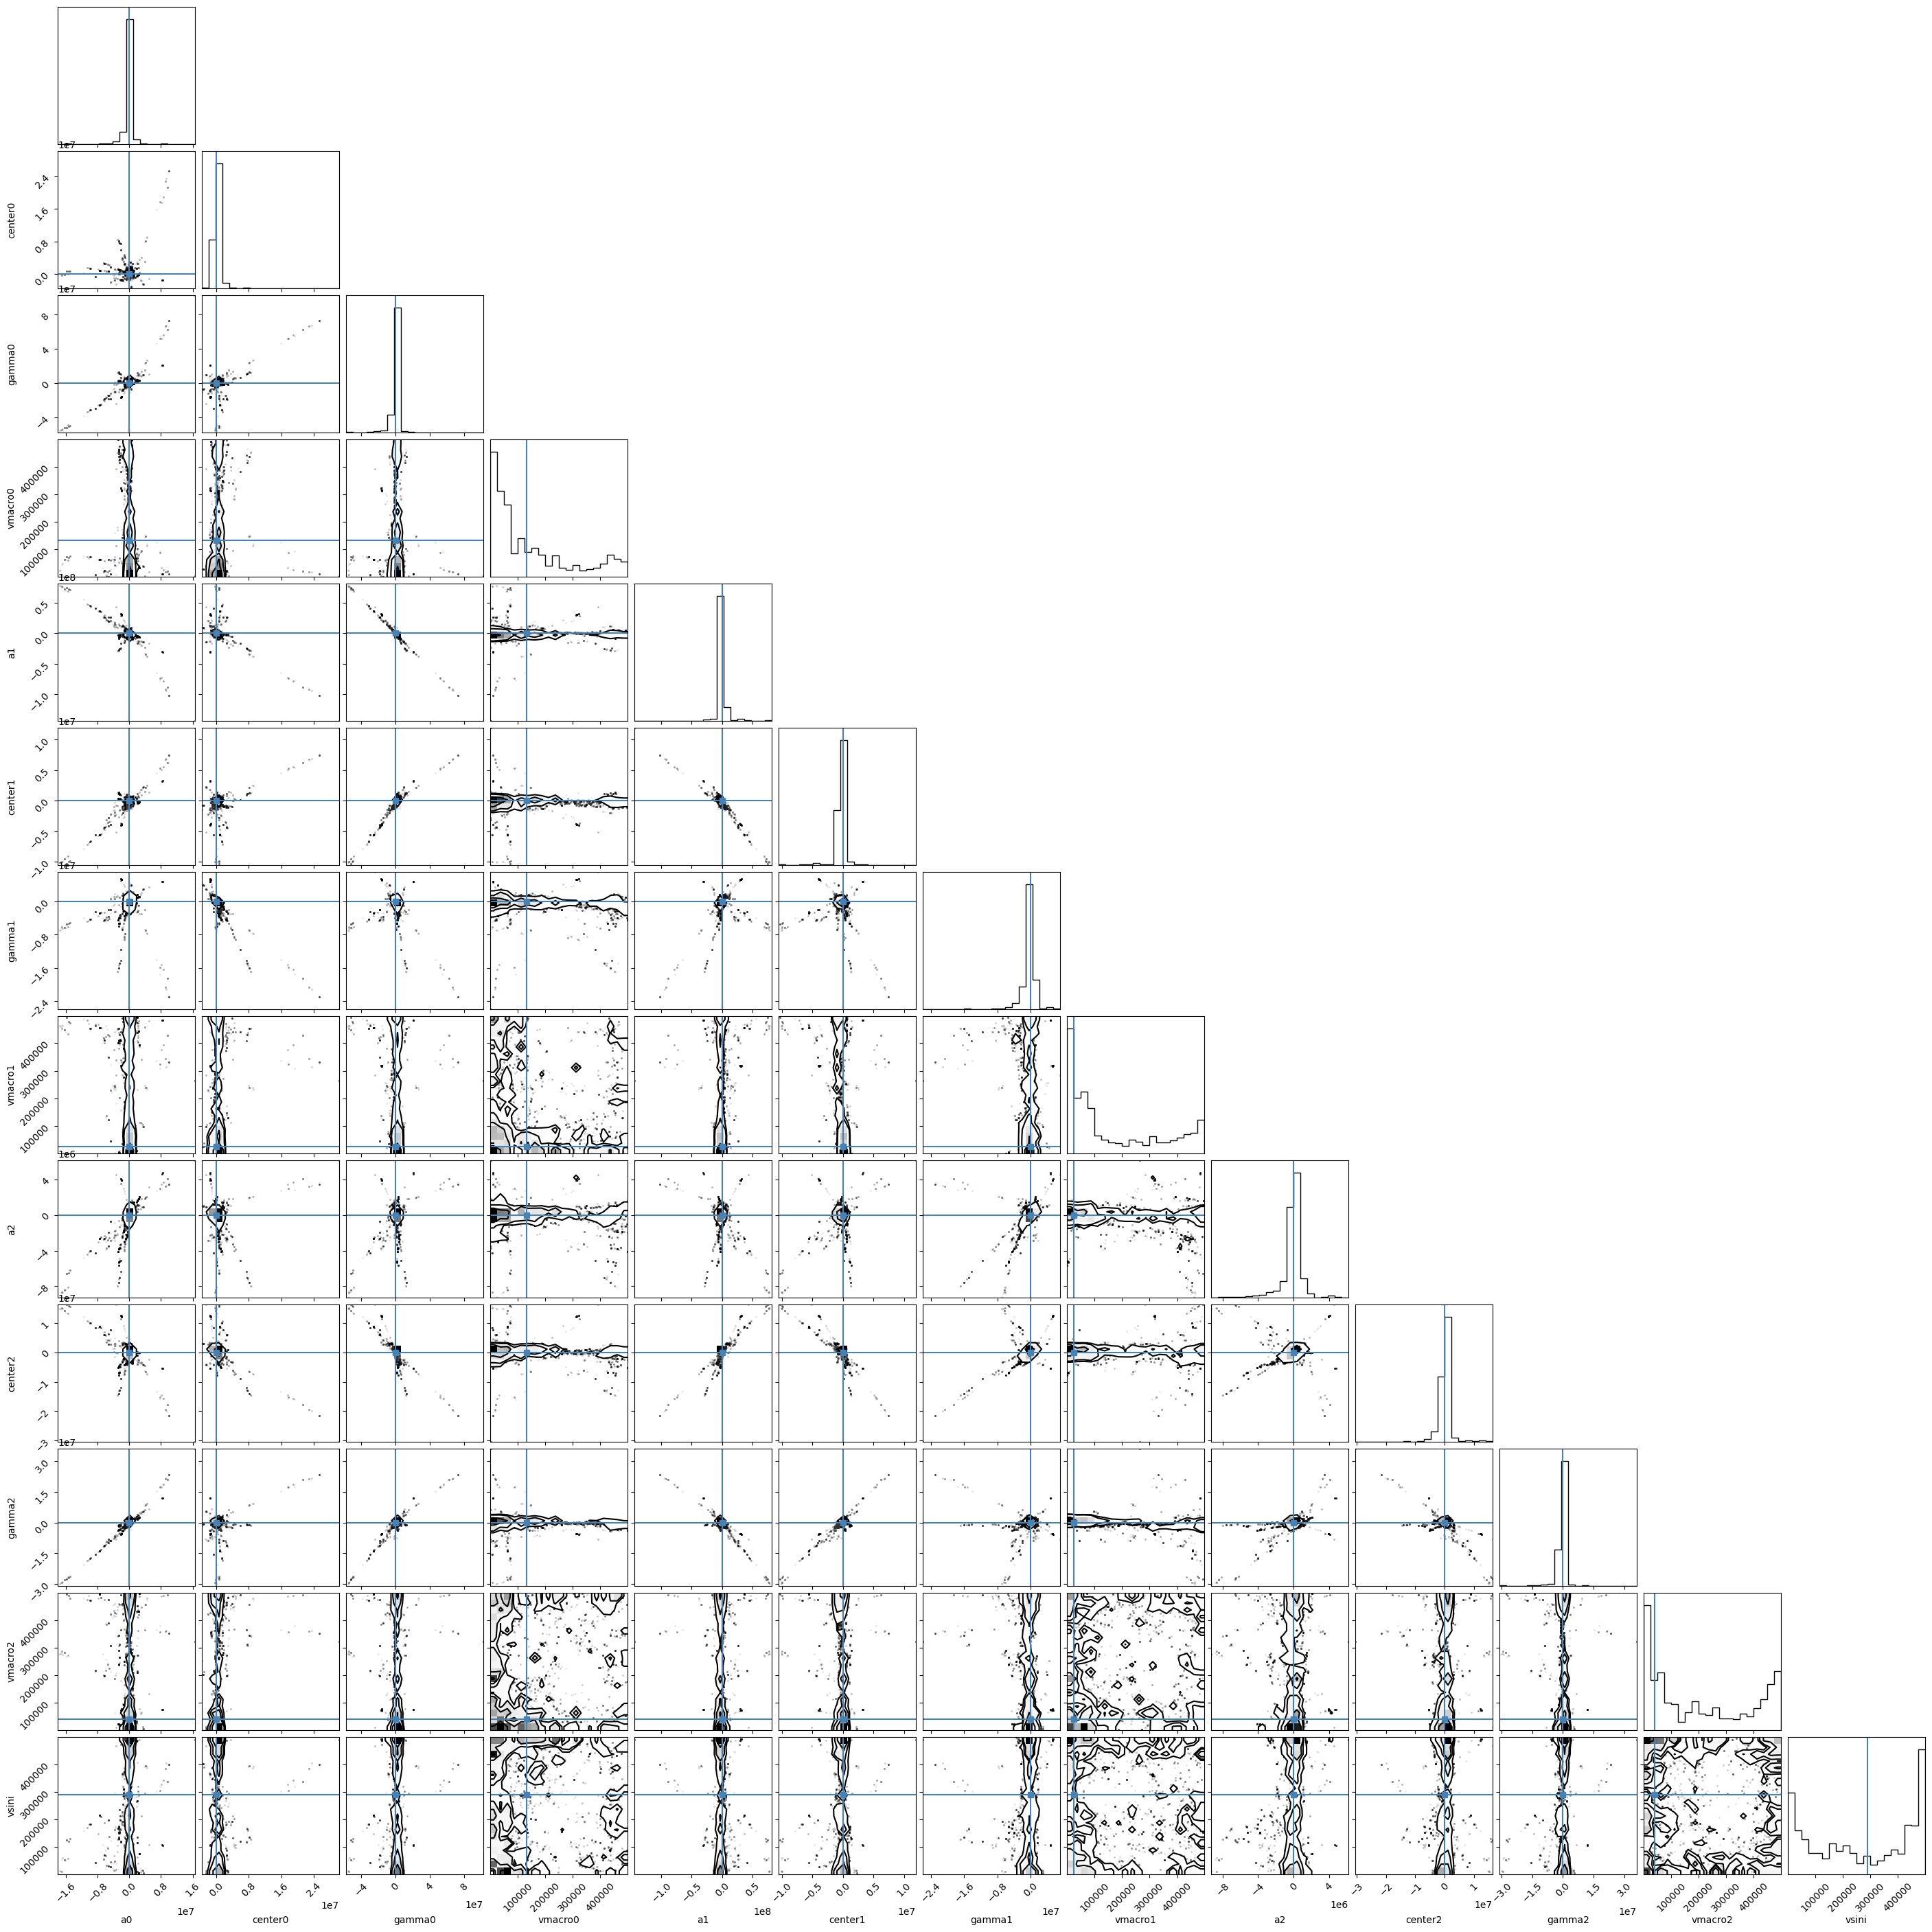

In [28]:
import emcee
import corner
from tqdm import tqdm

# Define the log likelihood function
def log_likelihood(params, wave, flux, line_centers, line_widths, wavelength_slices):
    wave_data, flux_data = generate_data(wave, flux, line_centers, line_widths, wavelength_slices)
    model = generate_broaden(params, line_centers, line_widths, wavelength_slices)
    residuals = flux_data - model
    # Assuming Gaussian uncertainties, calculate the log likelihood
    sigma = np.sqrt(np.mean(residuals**2))  # Assuming constant uncertainty for simplicity
    log_likelihood = -0.5 * np.sum((residuals / sigma)**2)
    return log_likelihood

# Define the log prior function
def log_prior(params):
    # Assuming flat priors for simplicity
    # Check if parameters are within allowed ranges
    for i, value in enumerate(params):
        key = list(result.params.keys())[i]
        if key.startswith('vmacro'):
            if value < 0 or value > 500000:
                return -np.inf
        elif key == 'vsini':
            if value < 0 or value > 500000:
                return -np.inf
    return 0.0

# Define the log probability function
def log_probability(params, wave, flux, line_centers, line_widths, wavelength_slices):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, wave, flux, line_centers, line_widths, wavelength_slices)

# Set up the initial positions of the walkers
nwalkers = 32  # Number of walkers
ndim = len(result.params)  # Dimensionality of the parameter space
initial_params = [np.array(list(result.params.valuesdict().values())) + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Set up the emcee sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(wave, flux, line_centers, line_widths, 1000))

# Run the MCMC sampler with progress indicators
nsteps = 500  # Number of steps
with tqdm(total=nsteps) as pbar:
    for _ in sampler.sample(initial_params, iterations=nsteps):
        pbar.update(1)

# Extract the chain and discard burn-in
chain = sampler.get_chain()
burnin = 100  # Number of burn-in steps
samples = sampler.get_chain(discard=burnin, flat=True)

# Plot the results using the corner plot
labels = [f"{param}" for param in result.params.keys()]
corner.corner(samples, labels=labels, truths=list(result.params.valuesdict().values()))

#### fix best fit line params and run sampler for vmacro and vsini

In [4]:
def macro_broaden_O(xdata, ydata, vmacro):
    c = 299792458 #~constants.c.cgs.value * units.cm.to(units.km)
    sq_pi = np.sqrt(np.pi)
    lambda0 = np.median(xdata)
    xspacing = xdata[1] - xdata[0]
    mr = vmacro * lambda0 / c
    ccr = 2 / (sq_pi * mr)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmr = abs(px) / mr
    profile = ccr * (np.exp(-pxmr ** 2) + sq_pi * pxmr * (erf(pxmr) - 1.0))

    before = ydata[int(-profile.size / 2 + 2):]
    after = ydata[:int(profile.size / 2 +1)] #add one to fix size mismatch
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    
    x2 = np.linspace(first, last, extended.size)  #newdata x array ==> handles edge effects

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return newydata

In [6]:
def macro_broaden(xdata, ydata, vR, vT, aT):
    c = 299792458 #~constants.c.cgs.value * units.cm.to(units.km)
    sq_pi = np.sqrt(np.pi)
    lambda0 = 4470 #np.median(xdata)
    xspacing = xdata[1] - xdata[0]


    mrR = vR * lambda0 / c
    mrT = vT * lambda0 / c
    ccrR = 2* (1-aT) / (sq_pi * mrR)
    ccrT = 2* aT / (sq_pi * mrT)

    px = np.arange(-len(xdata) / 2, len(xdata) / 2 + 1) * xspacing
    pxmrR = abs(px) / mrR
    pxmrT = abs(px) / mrT
    profile = ccrR * (np.exp(-pxmrR ** 2) + sq_pi * pxmrR * (erf(pxmrR) - 1.0)) + ccrT * (np.exp(-pxmrT ** 2) + sq_pi * pxmrT * (erf(pxmrT) - 1.0))

    before = ydata[int(-profile.size / 2 +2):]
    after = ydata[:int(profile.size / 2 +2)] #add one to fix size mismatch
    extended = np.r_[before, ydata, after]

    first = xdata[0] - float(int(profile.size / 2.0 + 0.5)) * xspacing
    last = xdata[-1] + float(int(profile.size / 2.0 + 0.5)) * xspacing
    
    x2 = np.linspace(first, last, extended.size)  #newdata x array ==> handles edge effects

    conv_mode = "valid"

    newydata = fftconvolve(extended, profile / profile.sum(), mode=conv_mode)

    return newydata

In [69]:
#header = fits.getheader('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')

In [70]:
#header

In [71]:
wave, flux = read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
mask = (wave >= 4465) & (wave <= 4478)
vsini = 150
# Apply the mask to select the corresponding wavelengths and flux values
wvl = wave[mask]
flx = flux[mask]

In [74]:
lmd =4471 #np.median(wvl)

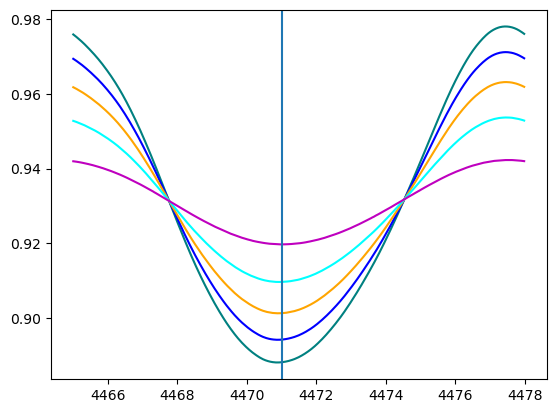

In [75]:
macro_fluxR = macro_broaden(wvl, flx, 200000, 400000 , 0)
macro_fluxT1 = macro_broaden(wvl, flx, 200000, 1000000, 0.2)
macro_fluxT2 = macro_broaden(wvl, flx, 200000, 1000000, 0.4)
macro_fluxT3 = macro_broaden(wvl, flx, 200000, 1000000, 0.6)
macro_fluxT4 = macro_broaden(wvl, flx, 200000, 1000000, 0.8)
macro_fluxT5= macro_broaden(wvl, flx, 200000, 1000000, 1)
#macro_flux = macro_broaden_O(wvl, flx, 300000)
#plt.plot(wvl, flx, color= 'black')
#plt.plot(wvl, macro_fluxR, color = 'red')
plt.plot(wvl, macro_fluxT1, color = 'teal')
plt.plot(wvl, macro_fluxT2, color = 'blue')
plt.plot(wvl, macro_fluxT3, color = 'orange')
plt.plot(wvl, macro_fluxT4, color = 'cyan')
plt.plot(wvl, macro_fluxT5, color = 'm')
plt.axvline(4470)
#plt.plot(wvl, macro_flux, color = 'blue')

In [5]:
def gauss(x,a,center,R, gamma):
  sigma = sigma = 4471/ (2.0 * R * np.sqrt(2.0 * np.log(2))) 
  return a*np.exp(-(x-center)**2/(2*sigma**2)) + gamma
wave = np.linspace(4460, 4480, 1000)
flux = gauss(wave, -0.4, 4470, 2000, 1)

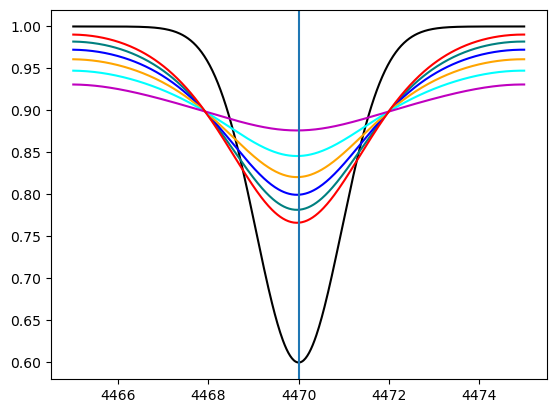

In [11]:
mask = (wave >= 4465) & (wave <= 4475)
#Apply the mask to select the corresponding wavelengths and flux values
wvl = wave[mask]
flx = flux[mask]

macro_fluxR= macro_broaden(wvl, flx, 200000, 800000, 0)
macro_fluxT1 = macro_broaden(wvl, flx, 200000, 800000, 0.2)
macro_fluxT2 = macro_broaden(wvl, flx, 200000, 800000, 0.4)
macro_fluxT3 = macro_broaden(wvl, flx, 200000, 800000, 0.6)
macro_fluxT4 = macro_broaden(wvl, flx, 200000, 800000, 0.8)
macro_fluxT5= macro_broaden(wvl, flx, 200000, 800000, 1)
plt.plot(wvl, flx, color= 'black')

plt.plot(wvl, macro_fluxT1, color = 'teal')
plt.plot(wvl, macro_fluxT2, color = 'blue')
plt.plot(wvl, macro_fluxT3, color = 'orange')
plt.plot(wvl, macro_fluxT4, color = 'cyan')
plt.plot(wvl, macro_fluxT5, color = 'm')
plt.plot(wvl, macro_fluxR, color = 'red')
plt.axvline(4470)


### deeming periodogram

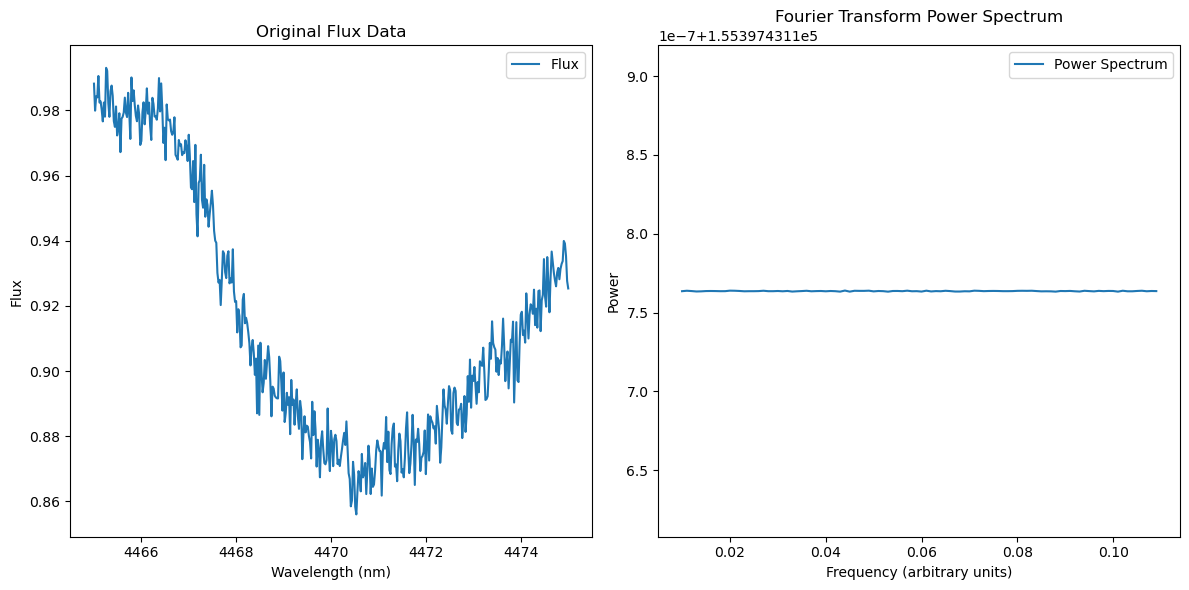

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def deeming1(T, X, F0, DF, N, NF):
    TWOPI = 2 * np.pi
    TPF = F0 * TWOPI
    FR = np.zeros(NF)
    S1 = np.zeros(NF)
    
    for K in range(NF):
        C0X = 0.0
        S0X = 0.0
        for I in range(N):
            TF = T[I] * TPF
            S0 = np.sin(TF)
            C0 = np.cos(TF)
            C0X += C0 * X[I]
            S0X += S0 * X[I]
        
        S1[K] = C0X * C0X + S0X * S0X
        FR[K] = TPF / TWOPI
        TPF += DF * TWOPI
    
    return FR, S1

def deeming2(T, X, F0, DF, N, NF):
    TWOPI = 2 * np.pi
    TPF = F0 * TWOPI
    TDF = DF * TWOPI
    SS = np.zeros(NF)
    SC = np.zeros(NF)
    
    for I in range(N):
        A = T[I]
        AF0 = A * TPF
        S0 = np.sin(AF0)
        C0 = np.cos(AF0)
        ADF = A * TDF
        SDF = np.sin(ADF)
        CDF = np.cos(ADF)
        XI = X[I]
        C0X = C0 * XI
        S0X = S0 * XI
        
        for K in range(NF):
            SS[K] += S0X
            SC[K] += C0X
            CTX = C0X
            C0X = CTX * CDF - S0X * SDF
            S0X = S0X * CDF + CTX * SDF
    
    TPF = F0
    S1 = np.zeros(NF)
    FR = np.zeros(NF)
    
    for K in range(NF):
        SSK = SS[K]
        SCK = SC[K]
        S1[K] = SCK * SCK + SSK * SSK
        FR[K] = TPF
        TPF += DF
    
    return FR, S1

# Sample data (replace with your actual data)

mask = (wave >= 4465) & (wave <= 4475)
#Apply the mask to select the corresponding wavelengths and flux values
wvl = wave[mask]
flx = flux[mask]

wavelengths = wvl
fluxes = flx
c = 3e8
# Convert wavelengths to consistent units (e.g., nanometers to meters if needed)
wavelengths_m = wavelengths * 1e-9  # convert nm to meters if needed

# Number of data points
N = len(wavelengths_m)

# Initial frequency and frequency increment
F0 = 0.01
DF = 0.001
NF = 100  # Number of frequency steps

# Call the Python version of deeming1
FR, S1 = deeming1(wavelengths_m, fluxes, F0, DF, N, NF)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(wavelengths, fluxes, label='Flux')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
plt.title('Original Flux Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(FR, S1, label='Power Spectrum')
plt.xlabel('Frequency (arbitrary units)')
plt.ylabel('Power')
plt.title('Fourier Transform Power Spectrum')
plt.legend()

plt.tight_layout()
plt.show()

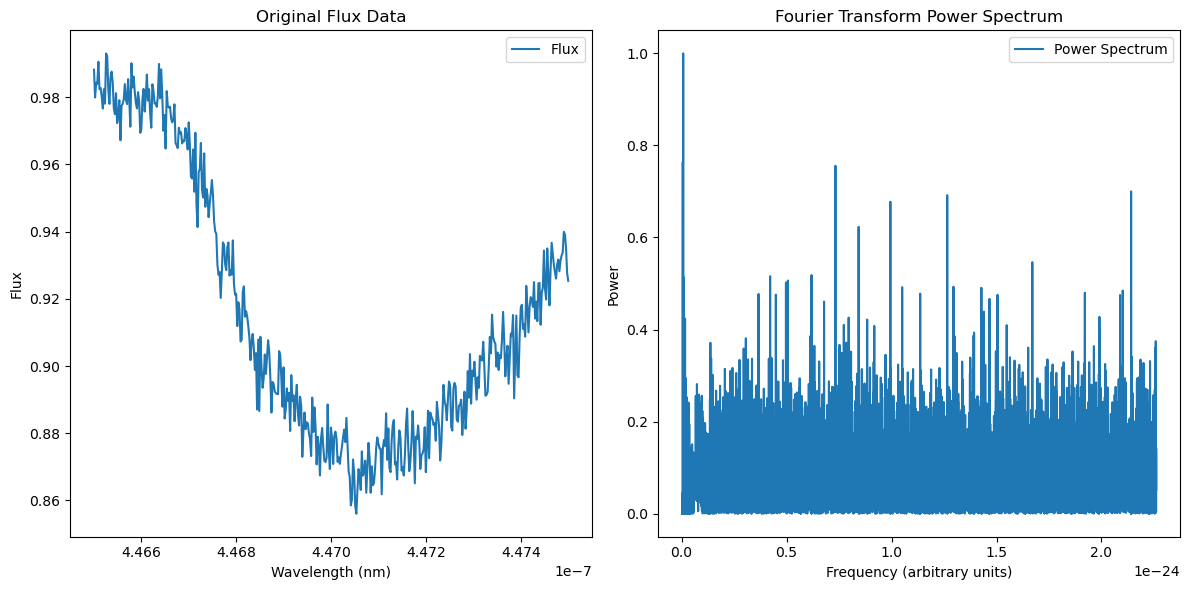

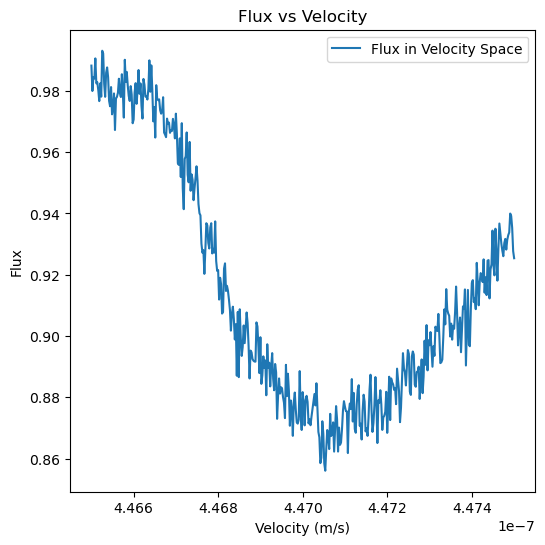

Frequencies and Power Spectrum:  (array([2.25903366e-27, 2.48493703e-27, 2.71084040e-27, ...,
       2.26061499e-24, 2.26084089e-24, 2.26106679e-24]), array([1.77529065e-04, 5.58075724e-04, 5.12676140e-05, ...,
       1.41839402e-01, 1.10469713e-01, 5.19993257e-02]))
Minima and Minvals:  (array([ 0.012,  0.014,  0.017, ...,  9.993,  9.997, 10.   ]), array([5.12676140e-05, 3.71113872e-05, 1.08966192e-04, ...,
       3.48261717e-03, 1.57000954e-03, 4.54641798e-02]))
Vsini values (x10^13):  [3.68889294e+13 3.16190823e+13 2.60392443e+13 ... 4.42977237e+10
 4.42799993e+10 4.42667153e+10]
Error:  2.258104530877221e-34


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy import constants, units

def deeming2(T, X, F0, DF, N, NF):
    TWOPI = 2 * np.pi
    TPF = F0 * TWOPI
    TDF = DF * TWOPI
    SS = np.zeros(NF)
    SC = np.zeros(NF)
    
    for I in range(N):
        A = T[I]
        AF0 = A * TPF
        S0 = np.sin(AF0)
        C0 = np.cos(AF0)
        ADF = A * TDF
        SDF = np.sin(ADF)
        CDF = np.cos(ADF)
        XI = X[I]
        C0X = C0 * XI
        S0X = S0 * XI
        
        for K in range(NF):
            SS[K] += S0X
            SC[K] += C0X
            CTX = C0X
            C0X = CTX * CDF - S0X * SDF
            S0X = S0X * CDF + CTX * SDF
    
    TPF = F0
    S1 = np.zeros(NF)
    FR = np.zeros(NF)
    
    for K in range(NF):
        SSK = SS[K]
        SCK = SC[K]
        S1[K] = SCK * SCK + SSK * SSK
        FR[K] = TPF
        TPF += DF
    
    return FR, S1

def vsini(wave, flux, epsilon=0.6, clam=None, window=None):
    cc = constants.c.to(units.AA / units.s).value

    if window is not None:
        keep = (window[0] <= wave) & (wave <= window[1])
        wave, flux = wave[keep], flux[keep]

    clam = clam or np.mean(wave)

    q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

    # Convert wavelengths to velocities using the Doppler formula
    c = 3.0e8  # Speed of light in m/s
    lambda_0 = np.mean(wave)  # Reference wavelength (midpoint of the provided wavelengths)
    velocities = c * (wave - lambda_0) / lambda_0

    # Number of data points
    N = len(wave)
    
    # Initial frequency and frequency increment
    F0 = 0.01
    DF = 0.001
    NF = 10000  # Number of frequency steps

    # Call the Python version of deeming2
    FR, S1 = deeming2(velocities, flux, F0, DF, N, NF)

    # Normalize the amplitudes
    S1 /= max(S1)

    # Find peaks (minima in the original spectrum)
    peaks, _ = find_peaks(-S1)
    minima = FR[peaks][:-1]
    minvals = S1[peaks][:-1]

    # Adjust frequencies for vsini calculation
    freqs = FR * clam / q1 / cc
    vsini_values = cc / clam * q1 / minima

    error = np.ptp(wave) * clam / q1 / cc

    return (freqs, S1), (minima, minvals), vsini_values / 10**13, error

# Sample data (replace with your actual data)
mask = (wave >= 4465) & (wave <= 4475)
#Apply the mask to select the corresponding wavelengths and flux values
wvl = wave[mask]
flx = flux[mask]

wavelengths = wvl * 1e-10
fluxes = flx

# Call the vsini function with deeming2
(freqs, ampls), (minima, minvals), vsini_values, error = vsini(wavelengths, fluxes)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(wavelengths, fluxes, label='Flux')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
plt.title('Original Flux Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(freqs, ampls, label='Power Spectrum')
plt.xlabel('Frequency (arbitrary units)')
plt.ylabel('Power')
plt.title('Fourier Transform Power Spectrum')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the spectrum in velocity space
plt.figure(figsize=(6, 6))
plt.plot(wavelengths, fluxes, label='Flux in Velocity Space')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Flux')
plt.title('Flux vs Velocity')
plt.legend()
plt.show()

print("Frequencies and Power Spectrum: ", (freqs, ampls))
print("Minima and Minvals: ", (minima, minvals))
print("Vsini values (x10^13): ", vsini_values)
print("Error: ", error)

### interesting things happen when you change the frequency increments!!!

In [56]:
def deeming2(T, X, F0, DF, N, NF):
    TWOPI = 2 * np.pi
    TPF = F0 * TWOPI
    TDF = DF * TWOPI
    SS = np.zeros(NF)
    SC = np.zeros(NF)
    
    for I in range(N):
        A = T[I]
        AF0 = A * TPF
        S0 = np.sin(AF0)
        C0 = np.cos(AF0)
        ADF = A * TDF
        SDF = np.sin(ADF)
        CDF = np.cos(ADF)
        XI = X[I]
        C0X = C0 * XI
        S0X = S0 * XI
        
        for K in range(NF):
            SS[K] += S0X
            SC[K] += C0X
            CTX = C0X
            C0X = CTX * CDF - S0X * SDF
            S0X = S0X * CDF + CTX * SDF
    
    TPF = F0
    S1 = np.zeros(NF)
    FR = np.zeros(NF)
    
    for K in range(NF):
        SSK = SS[K]
        SCK = SC[K]
        S1[K] = SCK * SCK + SSK * SSK
        FR[K] = TPF
        TPF += DF
    
    return FR, S1

def vsini(wave, flux, epsilon=0.6, clam=None, window=None):
    cc = constants.c.to(units.AA / units.s).value

    if window is not None:
        keep = (window[0] <= wave) & (wave <= window[1])
        wave, flux = wave[keep], flux[keep]

    clam = clam or np.mean(wave)

    q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4

    # Speed of light in m/s
    lambda_0 = np.mean(wave)  # Reference wavelength (midpoint of the provided wavelengths)
    velocities = c * (wave - lambda_0) / lambda_0

    # Number of data points
    N = len(wave)
    
    # Initial frequency and frequency increment
    F0 = 0.1
    DF = 0.01
    NF = 1000  # Number of frequency steps

    # Call the Python version of deeming2
    FR, S1 = deeming2(velocities, flux, F0, DF, N, NF)

    # Normalize the amplitudes
    S1 /= max(S1)

    # Find peaks (minima in the original spectrum)
    peaks, _ = find_peaks(-S1)
    minima = FR[peaks][:-1]
    minvals = S1[peaks][:-1]

    # Adjust frequencies for vsini calculation
    freqs = FR * clam / q1 / cc
    vsini_values = cc / clam * q1 / minima

    error = np.ptp(wave) * clam / q1 / cc

    return (freqs, S1), (minima, minvals), vsini_values / 10**13, error


In [57]:
clam = 6678
wave, flux= read_HERMES('00943975_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf_norm.fits')
result = vsini(wave, flux, clam = clam, window=[6670, 6686])
print('V(FT) is', max(result[2]), 'km/s')

V(FT) is 269.36771484484086 km/s


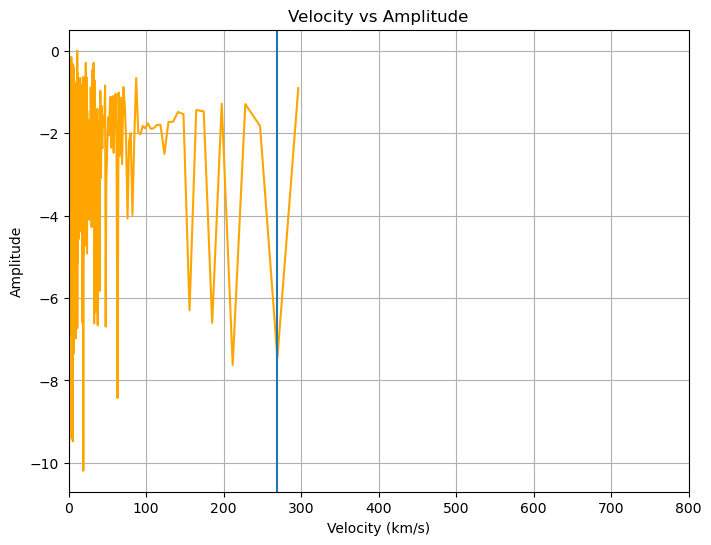

In [58]:
epsilon = 0.6
cc = constants.c.to(units.AA / units.s).value
q1 = 0.610 + 0.062 * epsilon + 0.027 * epsilon ** 2 + 0.012 * epsilon ** 3 + 0.004 * epsilon ** 4
freqs = result[0][0] /( clam / q1 / cc)
ampls = result[0][1]
def freq_to_velocity(freqs, clam, q1):
    cc = constants.c.to(units.AA / units.s).value
    return (cc / clam * q1 / freqs)/10**13

# Convert frequencies to velocities
velocities = freq_to_velocity(freqs, clam, q1)
log_ampls = np.log(ampls)


#svgol_freq = svg(log_ampls, window_length= 10, polyorder = 3, mode = 'interp')


# Plot velocity vs amplitude
plt.figure(figsize=(8, 6))
plt.plot(velocities, log_ampls, color = 'orange')
#plt.plot(velocities, svgol_freq, color = 'red')
plt.ylabel('Amplitude')
plt.xlabel('Velocity (km/s)')
plt.title('Velocity vs Amplitude')
plt.grid(True)
plt.xlim(0,800)
plt.axvline(max(result[2]))
#plt.ylim(0,0.1)
plt.show()